# Growth Factor Research

本篇报告会关注几个问题:

1. 2020年的Growth因子指数涨幅很好, 在ACAS因子分析中ICIR值也很大, 为什么在最后因子的选择中没有被选到?
2. Growth因子大类中, 哪一些因子比较有解释能力?

## 2020回顾

In [38]:
import pandas as pd
import numpy as np
import re
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import os
from datetime import datetime, timedelta
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams["axes.unicode_minus"] = False
import statsmodels.api as sm

In [2]:
DATA_ROOT = '~/projects/factormaster'
# START_DATE = pd.to_datetime('2014-02-28')
START_DATE = pd.to_datetime('2020-01-01')
END_DATE = pd.to_datetime('2020-10-31')

In [18]:
def display_indices(index_names = None):
    if not isinstance(index_names, list):
        index_names = [index_names]
    df_list = []
    # CSI300
    df = pd.read_excel(os.path.join(DATA_ROOT, 'data/features/AShareIndex.xlsx'), index_col=0, parse_dates=True)[['H00300.CSI']]
    df = df.loc[START_DATE: END_DATE]
    df = df / df.iloc[0]
    df_list.append(df)
    # aqumon1000
    for index in index_names:
        if index is None:
            name = 'aqumon1000'
            
        else:
            name = f'aqumon1000_{index.lower()}'
        df = pd.read_csv(os.path.join(DATA_ROOT, f'data/indices/{name}.csv'), index_col=0, parse_dates=True)
        df = df.loc[START_DATE: END_DATE]
        df = df / df.iloc[0]
        df_list.append(df)

    final_df = pd.concat(df_list, axis=1)
    final_df.plot()
    plt.show()
    
    excess_df = final_df[[i for i in final_df.columns if i != 'H00300.CSI']]
    excess_df = excess_df - final_df[['H00300.CSI']].values
    excess_df.plot()
    plt.show()

In [76]:
def display_anomaly(anomaly_name, suffix=None, calc_metrics=False, legend=True, suffix_filter=None):
    df = pd.read_csv(os.path.join(DATA_ROOT, f'data/payoffs/anomaly/{anomaly_name}.csv'), index_col=0, parse_dates=True)
    if isinstance(suffix, str):
        suffix = [suffix]
    if suffix is not None:
        columns = [f'{anomaly_name}_{i}' for i in suffix]
        df = df.loc[:, columns]
    elif suffix_filter is not None:
        columns = [i for i in df.columns if suffix_filter(i)]
        df = df.loc[:, columns]
    df = df.loc[START_DATE: END_DATE]
    (df + 1).cumprod().plot()
    if not legend:
        plt.gca().get_legend().remove()
    plt.show()
    
    if calc_metrics:
        metrics = pd.DataFrame(columns=df.columns, index=['rtn p.a.', 'vol p.a.', 'sharpe ratio', 'Amplitude', 'abs rtn p.a.'])
        metrics.loc['rtn p.a.'] = df.mean(axis=0)*252
        metrics.loc['vol p.a.'] = df.std(axis=0)*np.sqrt(252)
        metrics.loc['sharpe ratio'] = df.mean(axis=0) / df.std(axis=0) * np.sqrt(252)
        metrics.loc['Amplitude'] = (df + 1).cumprod().max() - (df + 1).cumprod().min()
        metrics.loc['abs rtn p.a.'] = df.abs().mean(axis=0) * 252
        display(metrics)

In [53]:
def _parse_factor_path(model_name, prefix):
    special_map = {'Carhart4': 'c4'}
    suffix = special_map.get(model_name, model_name)
    factor_path = os.path.join(DATA_ROOT, f'data/payoffs/pricing_factors/{model_name}/{prefix.lower()}_{suffix.lower()}.csv')
    return factor_path

def _load_model(factor_path, start_date, end_date):
    df = pd.read_csv(factor_path, index_col=0, parse_dates=True)
    df = df.loc[start_date: end_date]
    return df

def analyse_factor_on_model(factor, model_name, prefix, start_date, end_date, regression_length = 252):
    model_df = _load_model(_parse_factor_path(model_name, prefix), start_date, end_date)
    RF = model_df[['RF']]
    model_df['MKT'] = model_df['MKT'] - model_df['RF']
    model_df.drop('RF', axis=1, inplace=True)
    
    factor = factor.copy().loc[start_date: end_date]
    
    # all time correlation
    all_df = pd.concat([model_df, factor], axis=1)
    corr_df = all_df.corr().iloc[[-1], :-1]
    print("All Time Correlation")
    display(corr_df)
    
    # time series of correlation
    if regression_length > 0:
        ts_corr_df = pd.DataFrame(index = model_df.index[regression_length:], columns=model_df.columns)
        for i in range(regression_length, len(model_df.index)):
            ts_corr_df.loc[model_df.index[i]] = all_df.iloc[i-regression_length: i].corr().iloc[-1, :-1]
        print("Time Series of Correlation")
        ts_corr_df.plot()
        plt.show()
    
    # all time loading
    X = sm.add_constant(model_df)
    Y = factor
    m = sm.OLS(Y, X)
    rslt = m.fit()
    display(rslt.summary())
    print("=================")
    print(f"alpha p.a.: {(- RF['RF'] + rslt.params.iloc[0]).mean() * 252}")
    (rslt.resid - RF['RF'] + rslt.params.iloc[0] + 1).cumprod().plot()
    plt.gca().set_title("Cumulative Excess Return")
    plt.show()
    print(f"rtn p.a.: {(rslt.resid - RF['RF'] + rslt.params.iloc[0]).mean() * 252}")
    print(f"sharpe ratio: {(rslt.resid - RF['RF'] + rslt.params.iloc[0]).mean()/(rslt.resid - RF['RF'] + rslt.params.iloc[0]).std() * np.sqrt(252)}")
    print("=================")
    
    # time series loading
    if regression_length:
        ts_loading_df = pd.DataFrame(index = model_df.index[regression_length:], columns=model_df.columns.tolist())
        excess_rtn_df = pd.DataFrame(index = model_df.index[regression_length:], columns=['alpha'])
        for i in range(regression_length, len(model_df.index)):
            tmp = all_df.iloc[i-regression_length: i]
            X = tmp.iloc[:, :-1]
            X = sm.add_constant(X)
            Y = tmp.iloc[:, [-1]]
            rslt = sm.OLS(Y, X).fit()
            ts_loading_df.loc[model_df.index[i]] = rslt.params.values[1:]
            excess_rtn_df.loc[model_df.index[i]] = rslt.resid.iloc[-1] - RF['RF'].loc[model_df.index[i]] + rslt.params.values[0]
        ts_loading_df.plot()
        plt.gca().set_title("Time Series of Loading")
        plt.show()
        (excess_rtn_df + 1).cumprod().plot()
        plt.gca().set_title("Time Series Derived Excess Return")
        plt.show()
    
    return

In [6]:
def _parse_factor_path(model_name, prefix):
    special_map = {'Carhart4': 'c4'}
    suffix = special_map.get(model_name, model_name)
    factor_path = os.path.join(DATA_ROOT, f'data/payoffs/pricing_factors/{model_name}/{prefix.lower()}_{suffix.lower()}.csv')
    return factor_path

def _load_model(factor_path, start_date, end_date):
    df = pd.read_csv(factor_path, index_col=0, parse_dates=True)
    df = df.loc[start_date: end_date]
    return df

def display_factors(model_name, prefix, start_date, end_date):
    factor_path = _parse_factor_path(model_name, prefix)
    df = _load_model(factor_path, start_date, end_date)
    # plot daily rtn
    fig, axes = plt.subplots(len(df.columns), 1, figsize=(20 , 5 * len(df.columns)))
    fig.suptitle(f'Daily Return of {prefix.lower()} {model_name}', fontsize=18)
    for i in range(len(df.columns)):
        factor = df.columns[i]
        df[[factor]].plot(ax=axes[i])
    plt.show()
    # plot cumulative payoffs
    fig, axes = plt.subplots(len(df.columns), 1, figsize=(20 , 5 * len(df.columns)))
    fig.suptitle(f'Cumulative Payoffs of {prefix.lower()} {model_name}', fontsize=18)
    for i in range(len(df.columns)):
        factor = df.columns[i]
        (df[[factor]] + 1).cumprod().plot(ax=axes[i])
    plt.show()

### 市场回顾
选择Fama-French-3 因子模型作为市场定价模型

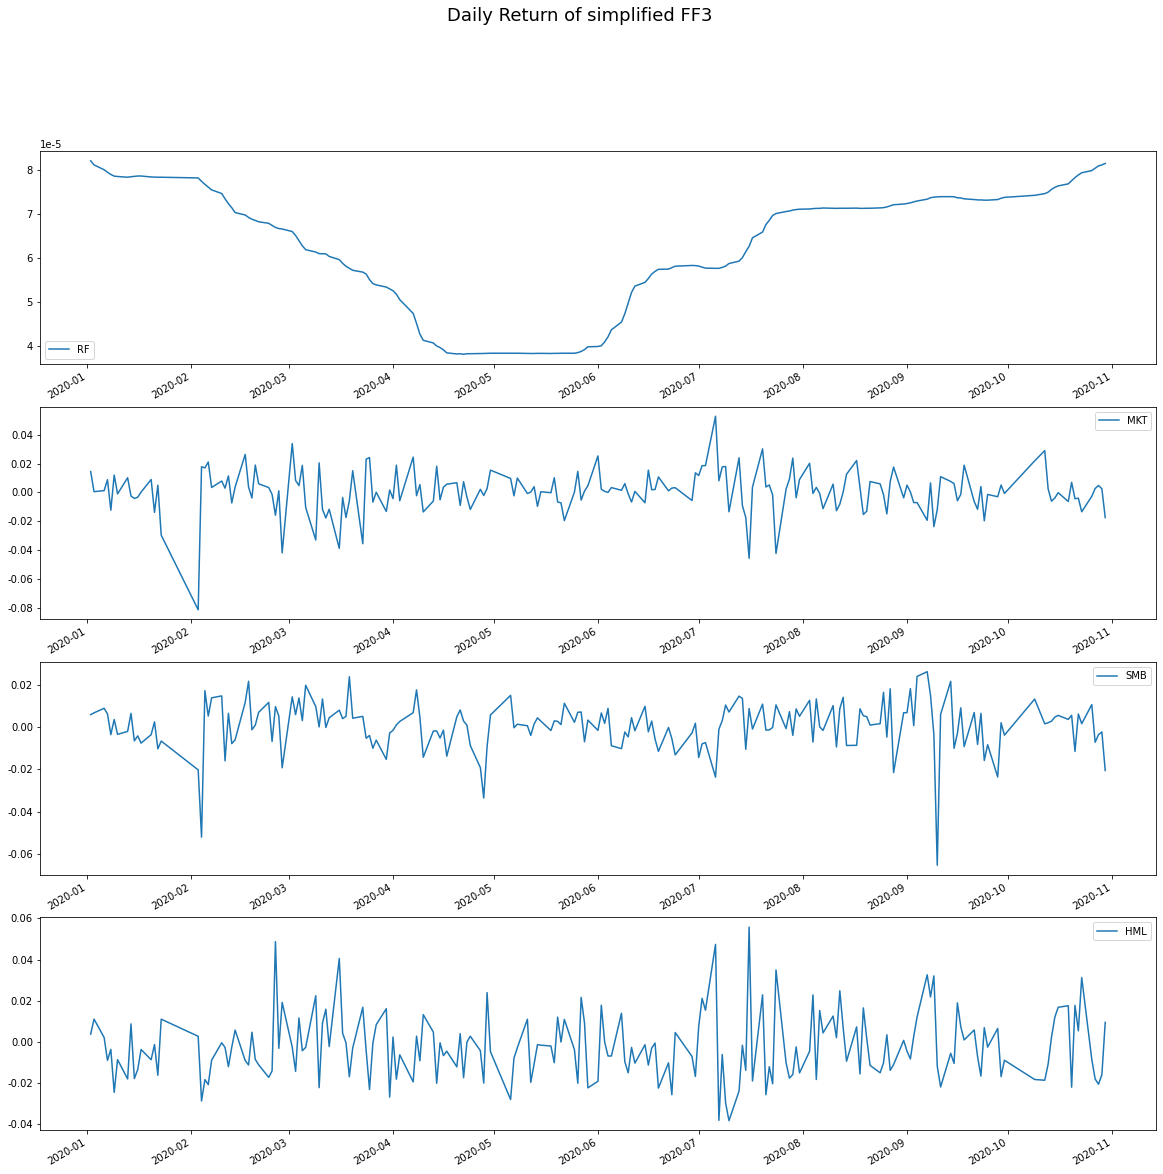

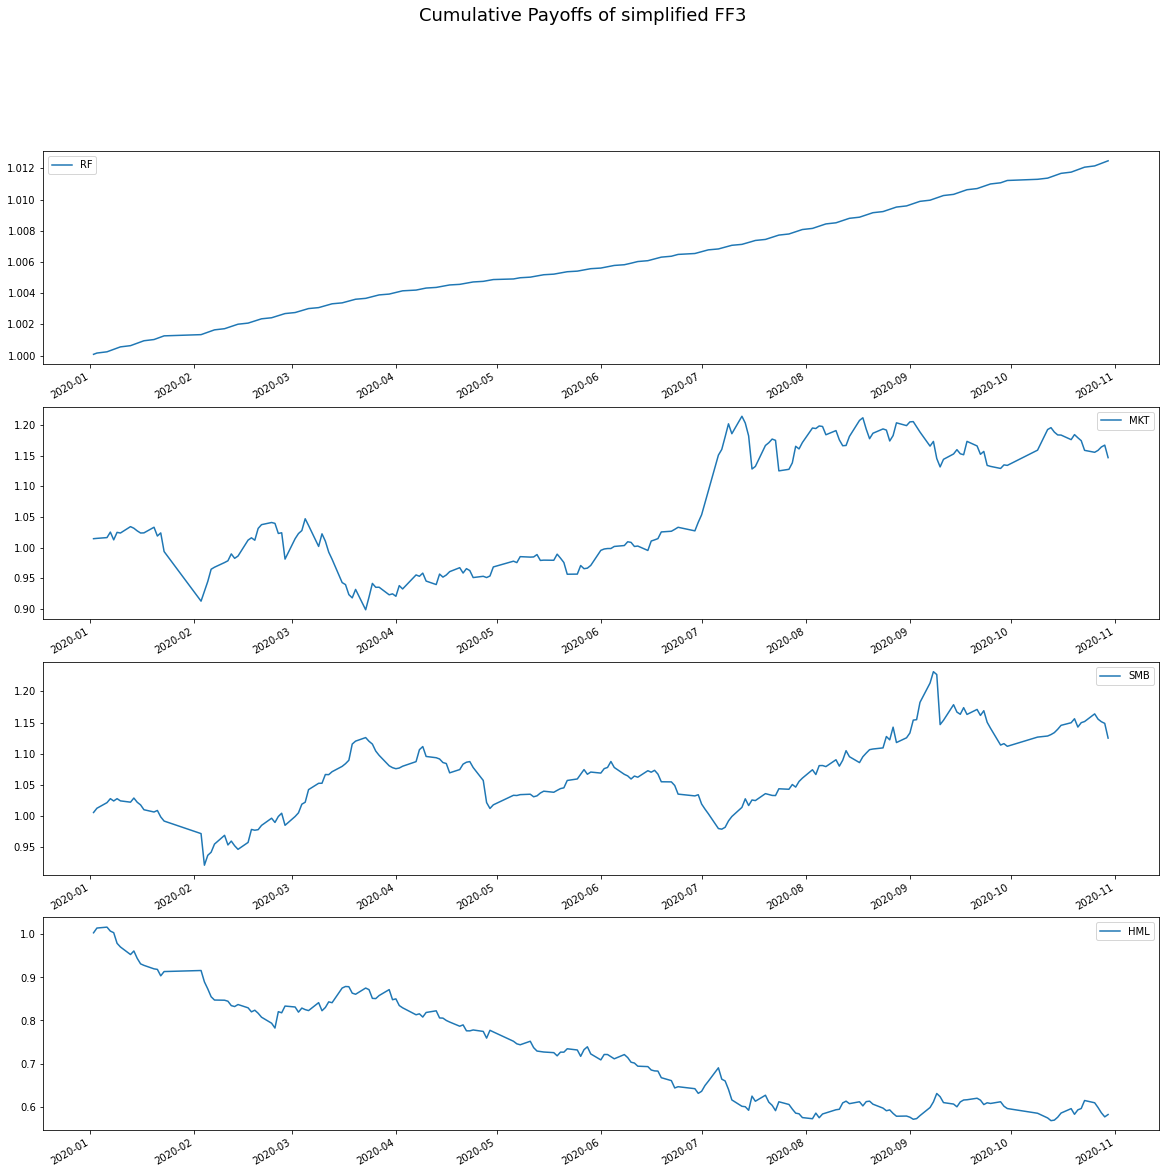

In [14]:
display_factors('FF3', 'simplified', START_DATE, END_DATE)

在10/31日的时候, 市场累计上涨15%左右, 与沪深300相仿.

SMB累计上涨15%左右

HML持续跑输, 亏损约为40%

### 因子指数回顾

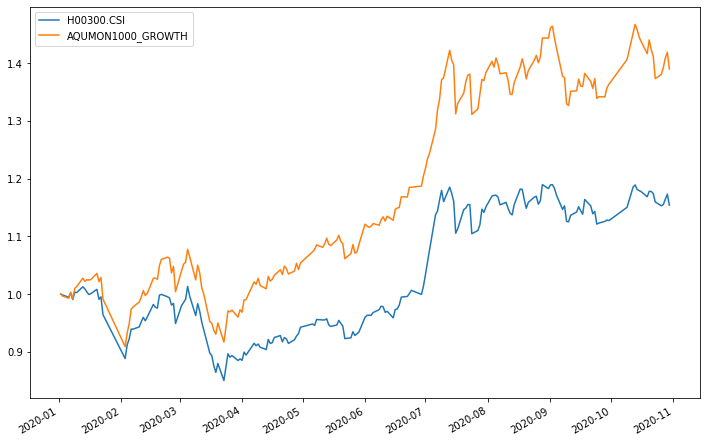

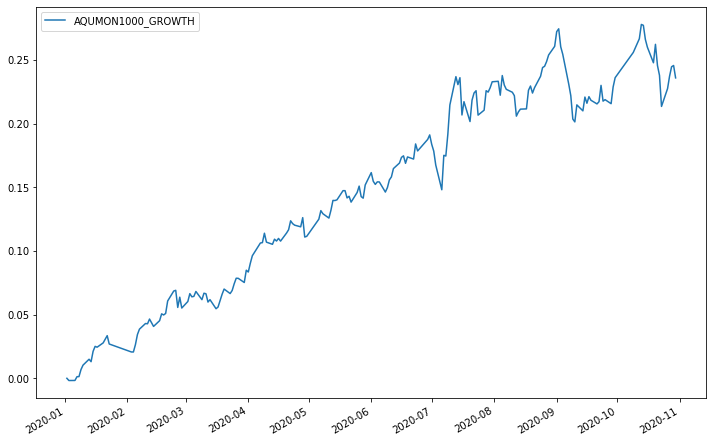

In [19]:
display_indices(['Growth'])

Grow因子指数在2020-01-01到2020-10-31期间获得了约25%的超额收益

### 因子回顾

In [15]:
growth_factor_list = [
    'BrrEGRO',
    'BrrSGRO',
    'NIGrowthYoY',
    'NIGrowthQoQ',
    'ORGrowthYoY',
    'ORGrowthQoQ',
    'OCFGrowthYoY',
    'ROADifferenceYoY',
    'ROEDifferenceYoY'
]

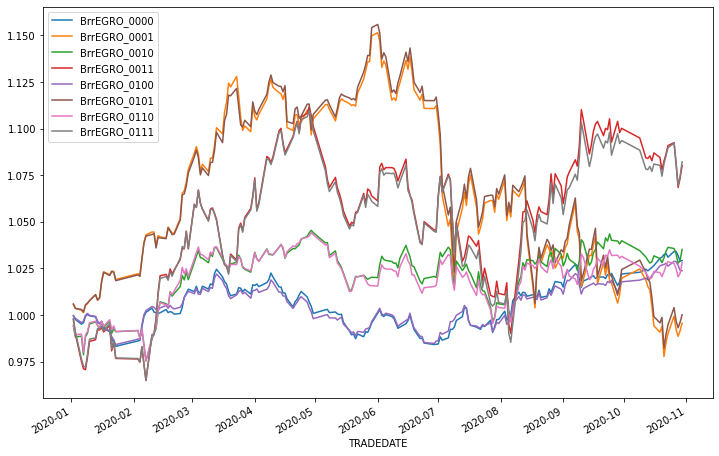

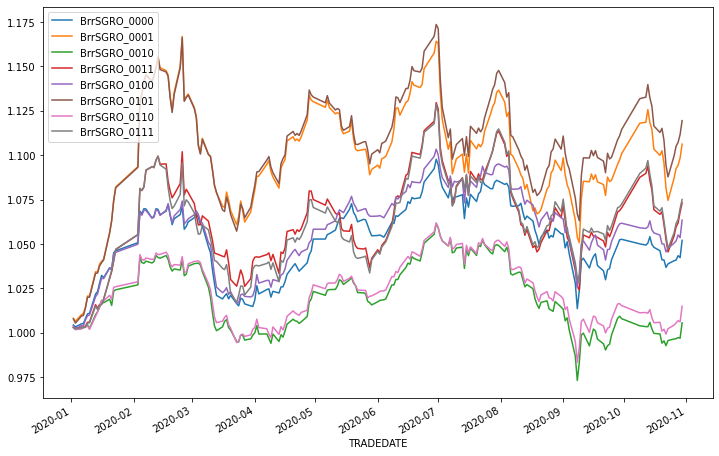

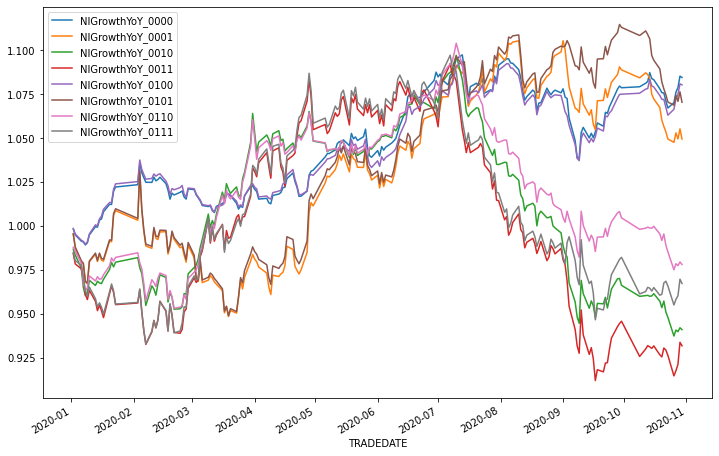

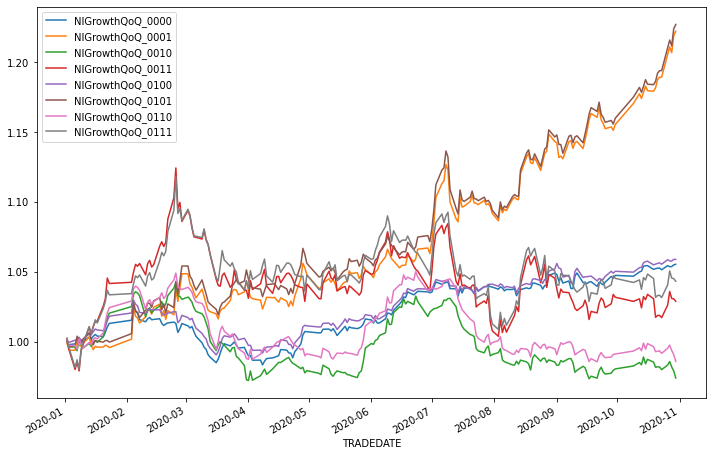

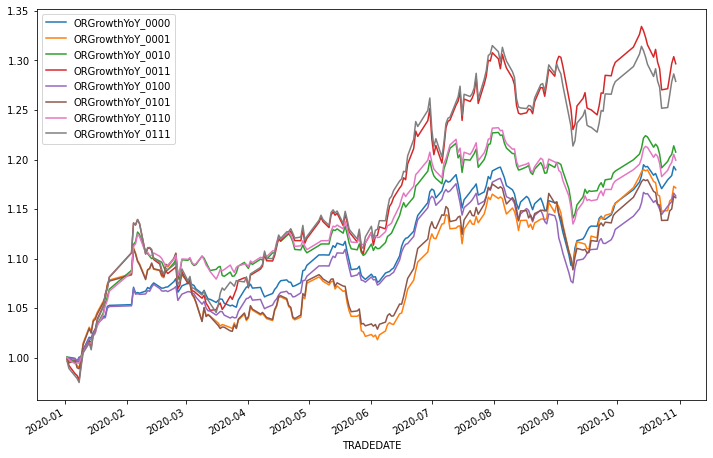

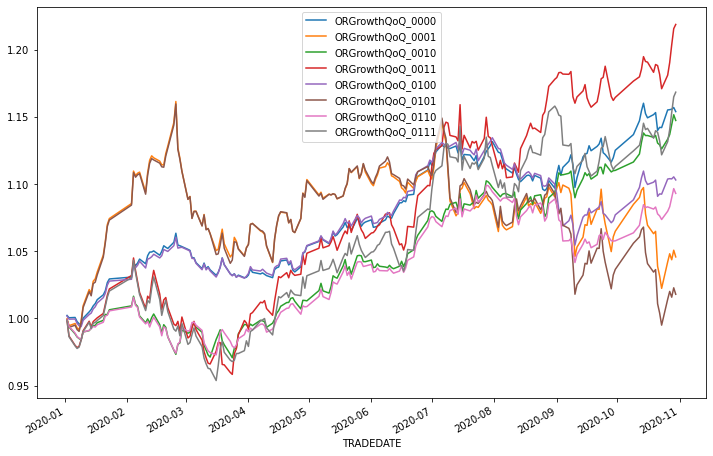

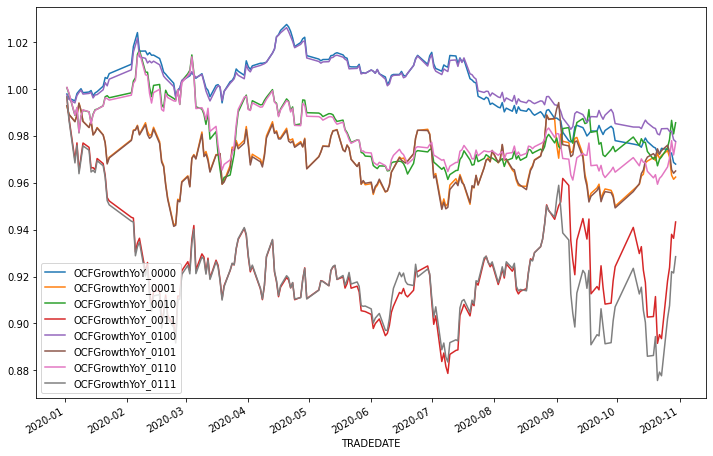

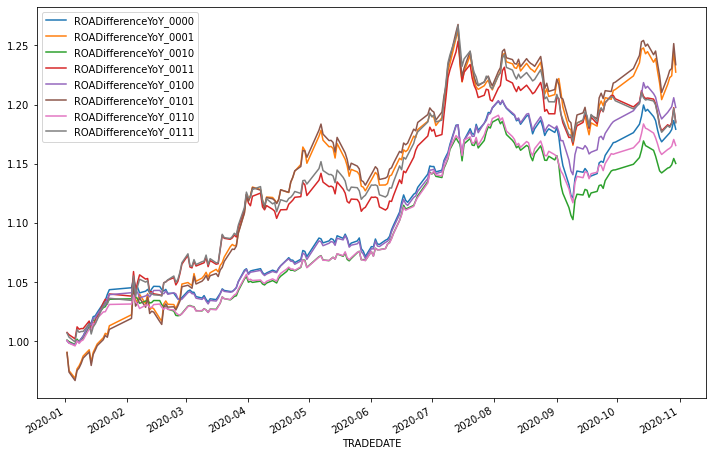

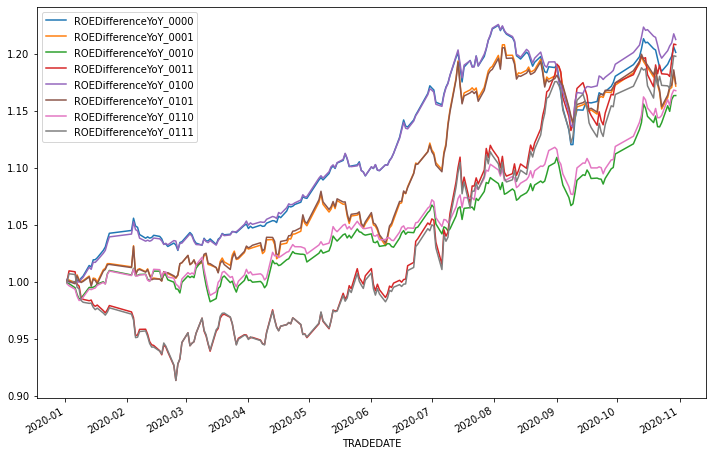

In [24]:
for factor in growth_factor_list:
    display_anomaly(factor)

其中 **BrrEGRO**, **BrrSGRO**, **NIGrowthYoY**, **NIGrowthQoQ**, **ORGrowthYoY**, **ORGrowthQoQ**, **OCFGrowthYoY** 是ACAS因子.

**NIGrowthYoY**, **ORGrowthYoY**, **ROADifferenceYoY** 和 **ROEDifferenceYoY** 是Grow因子指数用到的因子

在这些因子中, Grow因子指数用到的ROAyoy, ROEyoy, ORyoy 整族收益都有很强的向上的动量, 而 NIyoy这一族 则有一些分化

而且, 由于因子指数是纯多头组合, Growth因子指数表现好代表了它使用的这些因子在多头部分有比较好的表现.

相反, ACAS因子中没有被Grow因子指数使用到的因子则表现比较波动, 除了 NIGrowthQoQ 这一族中有两个表现非常好

### 因子筛检
去除一些不太合理, 重复的因子族成员.

因为Growth因子属于基本面因子, 周频和月频的差别不大, 为了方便起见, 只考虑所有月频的编制方式.

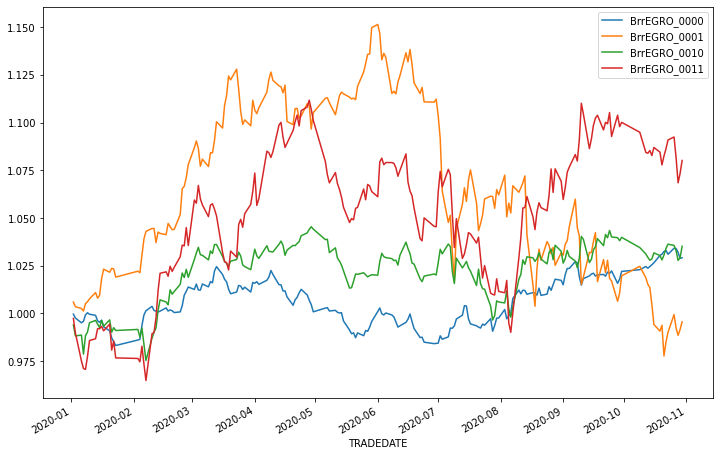

BrrEGRO_0000 BrrEGRO_0001 BrrEGRO_0010 BrrEGRO_0011
rtn p.a.        0.0373578   0.00311268    0.0464459     0.106572
vol p.a.        0.0430867     0.131718    0.0725545     0.133844
sharpe ratio     0.867039    0.0236315     0.640152     0.796241
Amplitude       0.0509506      0.17375    0.0701039     0.146905
abs rtn p.a.     0.544413      1.55959      0.89849      1.62574

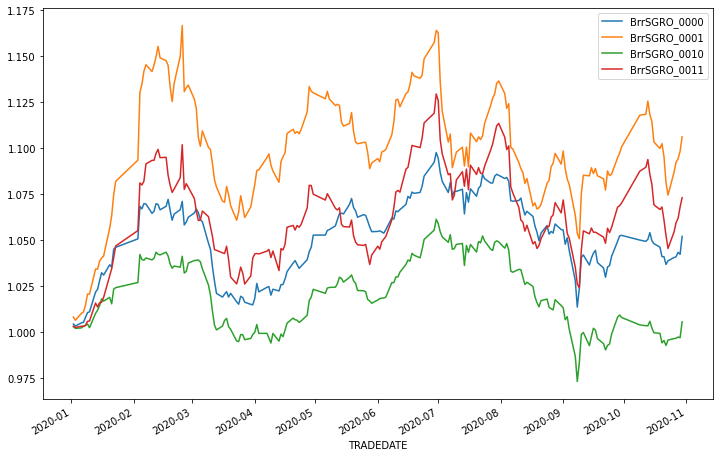

BrrSGRO_0000 BrrSGRO_0001 BrrSGRO_0010 BrrSGRO_0011
rtn p.a.         0.066964     0.135203   0.00935189    0.0947006
vol p.a.        0.0729955     0.121073    0.0675159     0.103082
sharpe ratio     0.917371      1.11671     0.138514     0.918692
Amplitude       0.0943781     0.160365    0.0882801     0.127022
abs rtn p.a.     0.859803      1.42745     0.774543      1.21821

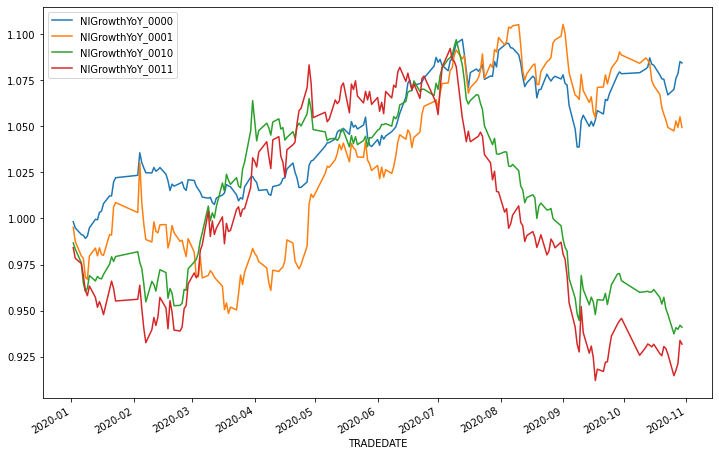

NIGrowthYoY_0000 NIGrowthYoY_0001 NIGrowthYoY_0010  \
rtn p.a.              0.10472        0.0668591       -0.0725722   
vol p.a.             0.064452         0.107984        0.0948591   
sharpe ratio          1.62478         0.619155        -0.765052   
Amplitude            0.108122         0.156919         0.159731   
abs rtn p.a.           0.7903          1.33357          1.15441   

             NIGrowthYoY_0011  
rtn p.a.           -0.0812691  
vol p.a.             0.128247  
sharpe ratio        -0.633691  
Amplitude             0.18034  
abs rtn p.a.          1.63965

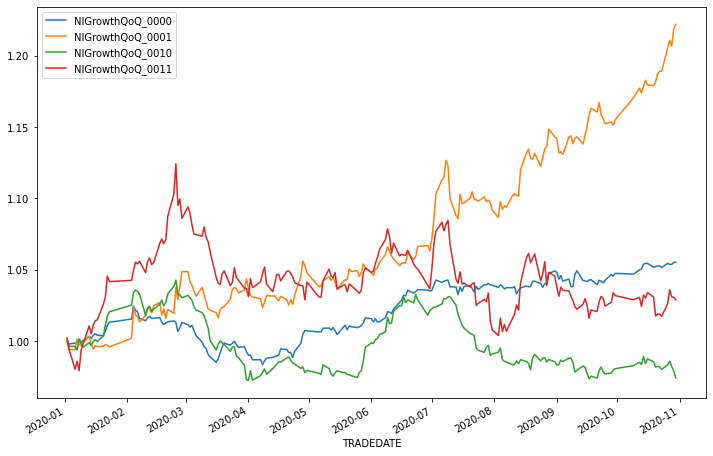

NIGrowthQoQ_0000 NIGrowthQoQ_0001 NIGrowthQoQ_0010  \
rtn p.a.            0.0691962         0.258087       -0.0312727   
vol p.a.            0.0415134        0.0909636        0.0623316   
sharpe ratio          1.66684          2.83725        -0.501715   
Amplitude             0.07194         0.227998        0.0703831   
abs rtn p.a.         0.511518          1.10238         0.774971   

             NIGrowthQoQ_0011  
rtn p.a.            0.0433965  
vol p.a.             0.120454  
sharpe ratio         0.360276  
Amplitude            0.145121  
abs rtn p.a.          1.47757

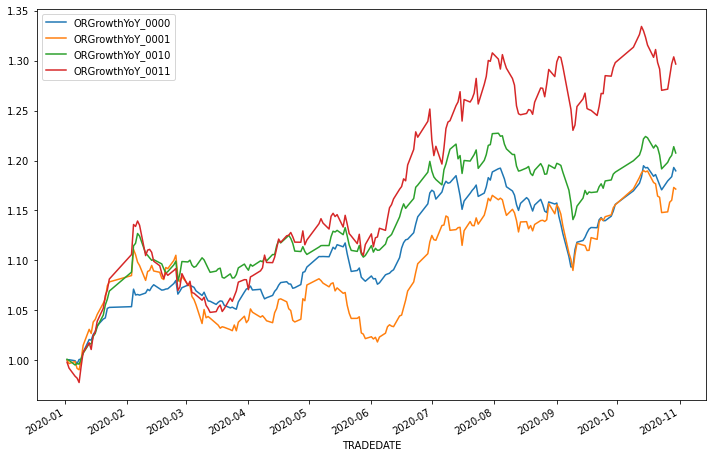

ORGrowthYoY_0000 ORGrowthYoY_0001 ORGrowthYoY_0010  \
rtn p.a.             0.223586         0.207179           0.2436   
vol p.a.            0.0848393         0.117022        0.0970606   
sharpe ratio          2.63541          1.77043          2.50978   
Amplitude            0.198375         0.199624         0.232205   
abs rtn p.a.          1.04142          1.43085          1.20873   

             ORGrowthYoY_0011  
rtn p.a.             0.339598  
vol p.a.              0.14453  
sharpe ratio          2.34967  
Amplitude            0.356732  
abs rtn p.a.          1.85741

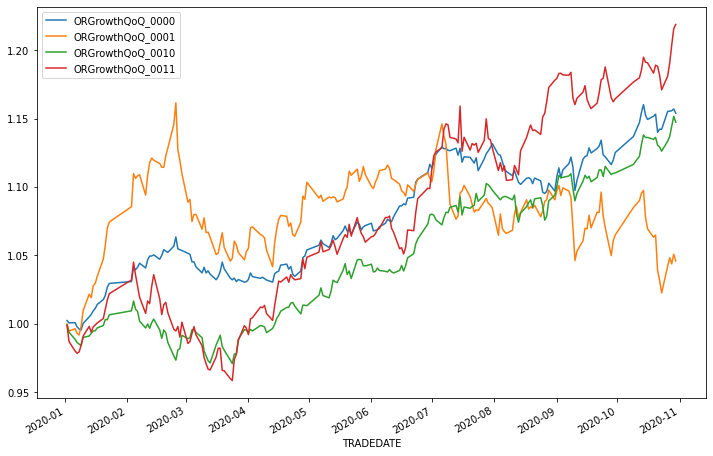

ORGrowthQoQ_0000 ORGrowthQoQ_0001 ORGrowthQoQ_0010  \
rtn p.a.             0.183698         0.066222         0.177051   
vol p.a.            0.0683252         0.137987        0.0767911   
sharpe ratio          2.68859         0.479915          2.30562   
Amplitude            0.164829         0.169788         0.180863   
abs rtn p.a.         0.856513          1.68243         0.972744   

             ORGrowthQoQ_0011  
rtn p.a.             0.257847  
vol p.a.             0.119879  
sharpe ratio          2.15088  
Amplitude            0.260415  
abs rtn p.a.          1.51345

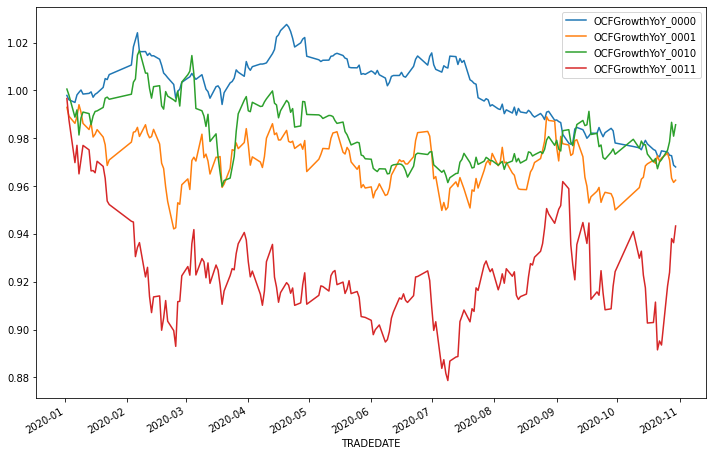

OCFGrowthYoY_0000 OCFGrowthYoY_0001 OCFGrowthYoY_0010  \
rtn p.a.            -0.0404428        -0.0453668        -0.0162267   
vol p.a.             0.0394291         0.0787333         0.0650288   
sharpe ratio          -1.02571         -0.576209         -0.249531   
Amplitude            0.0595788         0.0519143          0.056773   
abs rtn p.a.          0.476544          0.972424          0.764084   

             OCFGrowthYoY_0011  
rtn p.a.            -0.0651922  
vol p.a.              0.132133  
sharpe ratio         -0.493382  
Amplitude             0.117904  
abs rtn p.a.           1.58984

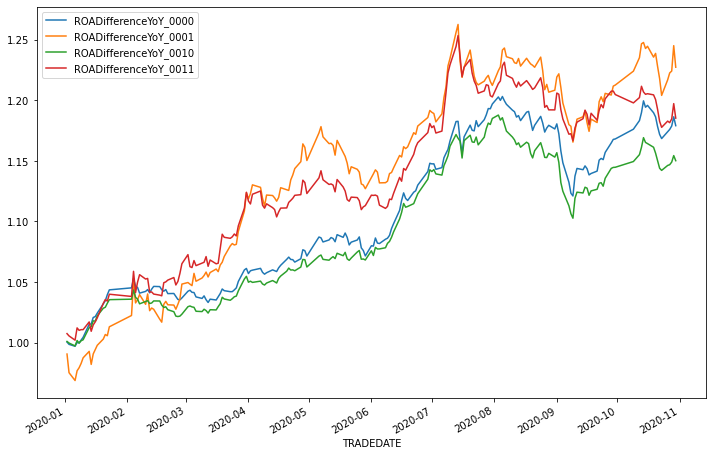

ROADifferenceYoY_0000 ROADifferenceYoY_0001  \
rtn p.a.                  0.211528              0.266343   
vol p.a.                 0.0743542              0.116085   
sharpe ratio               2.84487               2.29439   
Amplitude                 0.206316              0.294174   
abs rtn p.a.              0.922502               1.45456   

             ROADifferenceYoY_0010 ROADifferenceYoY_0011  
rtn p.a.                   0.17953              0.220191  
vol p.a.                 0.0670879             0.0975404  
sharpe ratio               2.67604               2.25743  
Amplitude                 0.190725              0.251593  
abs rtn p.a.              0.829605                1.2222

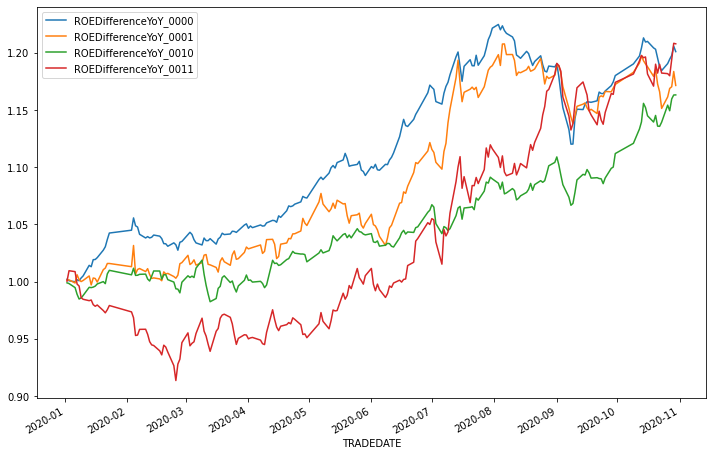

ROEDifferenceYoY_0000 ROEDifferenceYoY_0001  \
rtn p.a.                  0.235319              0.206432   
vol p.a.                 0.0802679              0.109071   
sharpe ratio               2.93167               1.89264   
Amplitude                 0.224952              0.210716   
abs rtn p.a.              0.976925                 1.324   

             ROEDifferenceYoY_0010 ROEDifferenceYoY_0011  
rtn p.a.                  0.195024              0.249135  
vol p.a.                 0.0837995              0.140637  
sharpe ratio               2.32727               1.77148  
Amplitude                  0.18082               0.29484  
abs rtn p.a.               1.02707               1.75883

In [32]:
suffix_filter = lambda x: True if int(x.split('_')[-1][1]) == 0 else False
for factor in growth_factor_list:
    display_anomaly(factor, calc_metrics=True, suffix_filter=suffix_filter)

原则上我们希望编制方法中要考虑市值中性和行业中性. 其中市值中性是在最后计算payoff的实现, 不会影响选中的券, 而行业中性只能在计算因子的时候做, 会影响到选中的券.

做不做行业中性得到的因子表现可能很不一样.

这些因子的表现可以分为几类:
1. 不论什么编制方法都表现的类似. 说明在行业/市值上没有特别的暴露度, 例如: ROEDifferenceYoY, ROEDifferenceYoY, ORGrowthYoY, BrrSGRO
    1. 其中, ROEDifferenceYoY, ROADifferenceYoY, ORGrowthYoY的趋势都是向上的, 而且这3个因子都是Growth因子指数所用因子的重要组成部分(3/4)
    2. 而BrrSGRO虽然不同的编制方法表现类似, 但是整体表现都是震荡的
2. 根据是否做行业中性分为2组. 例如: NIGrowthYoY, NIGrowthQoQ
3. 根据是否做市值中性分为2组. 例如: OCFGrowYoY
4. 没有特别的规律. 例如: BrrEGRO, ORGrowthQoQ

### 因子分析

#### ROEDifferenceYoY

All Time Correlation


MKT       SMB       HML
ROEDifferenceYoY_0000  0.235655 -0.290866 -0.480407

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     ROEDifferenceYoY_0000   R-squared:                       0.309
Model:                               OLS   Adj. R-squared:                  0.299
Method:                    Least Squares   F-statistic:                     29.08
Date:                   Wed, 13 Jan 2021   Prob (F-statistic):           1.38e-15
Time:                           16:48:26   Log-Likelihood:                 807.06
No. Observations:                    199   AIC:                            -1606.
Df Residuals:                        195   BIC:                            -1593.
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      2.063      0.040    2.76e-05       0.001
MKT            0.0194      0.022      0.872      0.385      -0.025       0.063
SMB           -0.1237      0.026     -4.671      0.000      -0.176      -0.071
HML           -0.1431      0.021     -6.761      0.000      -0.185      -0.101
==============================================================================
Omnibus:                        5.737   Durbin-Watson:                   1.582
Prob(Omnibus):                  0.057   Jarque-Bera (JB):                8.732
Skew:                          -0.005   Prob(JB):                       0.0127
Kurtosis:                       4.026   Cond. No.                         90.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

alpha p.a.: 0.1428290066479385


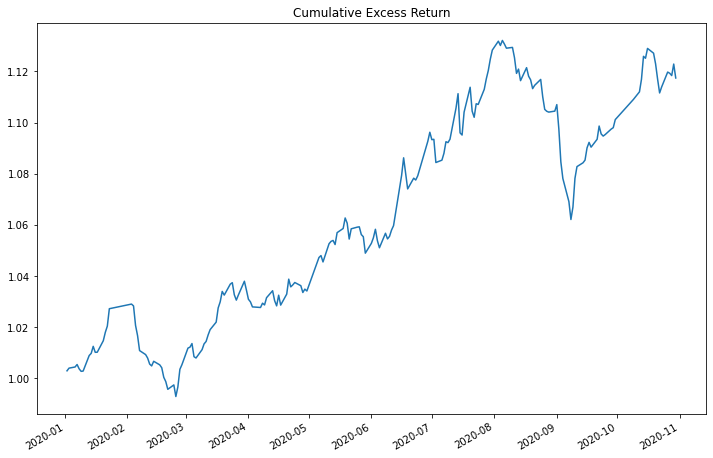

rtn p.a.: 0.14282900664793838
sharpe ratio: 2.1404716077497983


In [54]:
anomaly_name = 'ROEDifferenceYoY'
suffix = '0000'
anomaly = pd.read_csv(os.path.join(DATA_ROOT, f'data/payoffs/anomaly/{anomaly_name}.csv'), index_col=0, parse_dates=True)[[f'{anomaly_name}_{suffix}']]
analyse_factor_on_model(anomaly , "FF3", "simplified", START_DATE, END_DATE, regression_length=0)

All Time Correlation


MKT       SMB       HML
ROEDifferenceYoY_0001  0.261871 -0.075641 -0.516207

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     ROEDifferenceYoY_0001   R-squared:                       0.272
Model:                               OLS   Adj. R-squared:                  0.261
Method:                    Least Squares   F-statistic:                     24.32
Date:                   Wed, 13 Jan 2021   Prob (F-statistic):           2.06e-13
Time:                           16:48:41   Log-Likelihood:                 740.87
No. Observations:                    199   AIC:                            -1474.
Df Residuals:                        195   BIC:                            -1461.
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      0.635      0.526      -0.001       0.001
MKT            0.0248      0.031      0.798      0.426      -0.037       0.086
SMB           -0.0374      0.037     -1.011      0.313      -0.110       0.036
HML           -0.2138      0.030     -7.244      0.000      -0.272      -0.156
==============================================================================
Omnibus:                       20.183   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.530
Skew:                          -0.297   Prob(JB):                     2.64e-14
Kurtosis:                       5.681   Cond. No.                         90.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

alpha p.a.: 0.05232767474475389


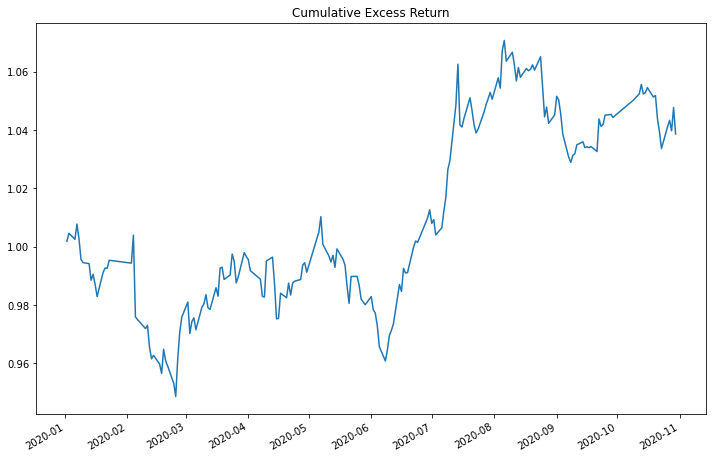

rtn p.a.: 0.052327674744753645
sharpe ratio: 0.5623460888810934


In [55]:
anomaly_name = 'ROEDifferenceYoY'
suffix = '0001'
anomaly = pd.read_csv(os.path.join(DATA_ROOT, f'data/payoffs/anomaly/{anomaly_name}.csv'), index_col=0, parse_dates=True)[[f'{anomaly_name}_{suffix}']]
analyse_factor_on_model(anomaly , "FF3", "simplified", START_DATE, END_DATE, regression_length=0)

All Time Correlation


MKT       SMB      HML
ROEDifferenceYoY_0010  0.038323 -0.099436 -0.29207

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     ROEDifferenceYoY_0010   R-squared:                       0.102
Model:                               OLS   Adj. R-squared:                  0.088
Method:                    Least Squares   F-statistic:                     7.345
Date:                   Wed, 13 Jan 2021   Prob (F-statistic):           0.000109
Time:                           16:48:42   Log-Likelihood:                 772.35
No. Observations:                    199   AIC:                            -1537.
Df Residuals:                        195   BIC:                            -1524.
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.478      0.141      -0.000       0.001
MKT           -0.0354      0.027     -1.331      0.185      -0.088       0.017
SMB           -0.0387      0.032     -1.226      0.221      -0.101       0.024
HML           -0.1112      0.025     -4.414      0.000      -0.161      -0.062
==============================================================================
Omnibus:                       12.426   Durbin-Watson:                   1.806
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               15.905
Skew:                           0.442   Prob(JB):                     0.000352
Kurtosis:                       4.066   Cond. No.                         90.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

alpha p.a.: 0.1195048635346326


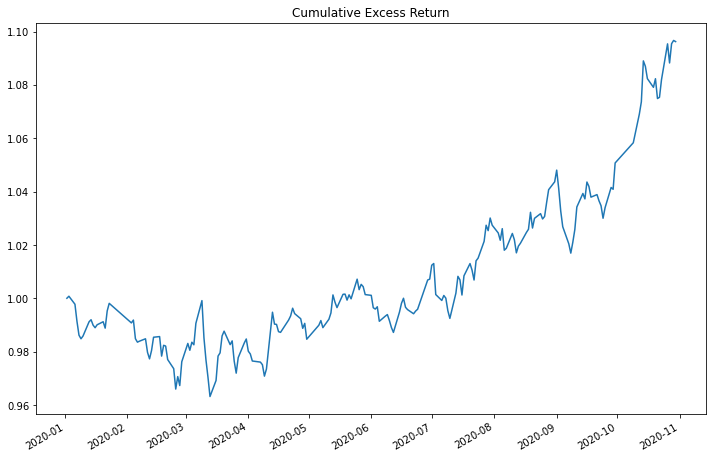

rtn p.a.: 0.11950486353463256
sharpe ratio: 1.504593445420229


In [56]:
anomaly_name = 'ROEDifferenceYoY'
suffix = '0010'
anomaly = pd.read_csv(os.path.join(DATA_ROOT, f'data/payoffs/anomaly/{anomaly_name}.csv'), index_col=0, parse_dates=True)[[f'{anomaly_name}_{suffix}']]
analyse_factor_on_model(anomaly , "FF3", "simplified", START_DATE, END_DATE, regression_length=0)

All Time Correlation


MKT       SMB       HML
ROEDifferenceYoY_0011 -0.10258 -0.033642 -0.285875

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     ROEDifferenceYoY_0011   R-squared:                       0.144
Model:                               OLS   Adj. R-squared:                  0.131
Method:                    Least Squares   F-statistic:                     10.94
Date:                   Wed, 13 Jan 2021   Prob (F-statistic):           1.14e-06
Time:                           16:48:59   Log-Likelihood:                 674.14
No. Observations:                    199   AIC:                            -1340.
Df Residuals:                        195   BIC:                            -1327.
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.880      0.380      -0.001       0.002
MKT           -0.1631      0.043     -3.749      0.000      -0.249      -0.077
SMB           -0.0053      0.052     -0.102      0.919      -0.107       0.097
HML           -0.2269      0.041     -5.497      0.000      -0.308      -0.145
==============================================================================
Omnibus:                        2.574   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.276   Jarque-Bera (JB):                2.173
Skew:                           0.226   Prob(JB):                        0.337
Kurtosis:                       3.242   Cond. No.                         90.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

alpha p.a.: 0.11613367813733314


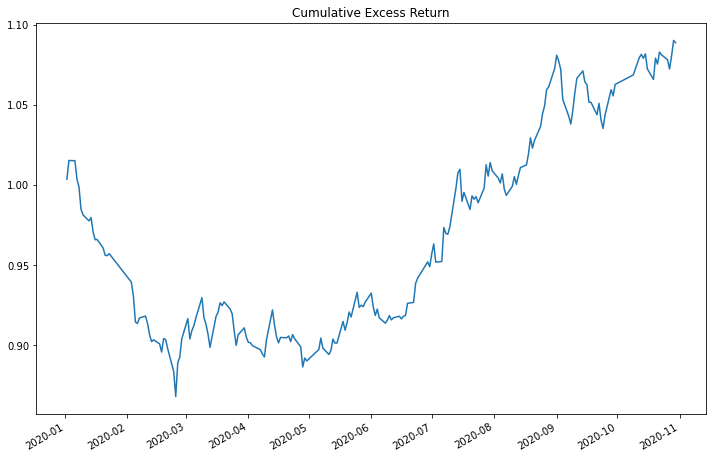

rtn p.a.: 0.1161336781373331
sharpe ratio: 0.8924562117985796


In [57]:
anomaly_name = 'ROEDifferenceYoY'
suffix = '0011'
anomaly = pd.read_csv(os.path.join(DATA_ROOT, f'data/payoffs/anomaly/{anomaly_name}.csv'), index_col=0, parse_dates=True)[[f'{anomaly_name}_{suffix}']]
analyse_factor_on_model(anomaly , "FF3", "simplified", START_DATE, END_DATE, regression_length=0)

0000的编制方案效果最好.

#### ROADifferenceYoY

All Time Correlation


MKT       SMB       HML
ROADifferenceYoY_0000  0.261233 -0.261949 -0.411045

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     ROADifferenceYoY_0000   R-squared:                       0.243
Model:                               OLS   Adj. R-squared:                  0.231
Method:                    Least Squares   F-statistic:                     20.88
Date:                   Wed, 13 Jan 2021   Prob (F-statistic):           9.01e-12
Time:                           17:43:01   Log-Likelihood:                 813.21
No. Observations:                    199   AIC:                            -1618.
Df Residuals:                        195   BIC:                            -1605.
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      2.065      0.040    2.74e-05       0.001
MKT            0.0387      0.022      1.789      0.075      -0.004       0.081
SMB           -0.1054      0.026     -4.103      0.000      -0.156      -0.055
HML           -0.1037      0.021     -5.056      0.000      -0.144      -0.063
==============================================================================
Omnibus:                        5.901   Durbin-Watson:                   1.692
Prob(Omnibus):                  0.052   Jarque-Bera (JB):                9.120
Skew:                           0.010   Prob(JB):                       0.0105
Kurtosis:                       4.049   Cond. No.                         90.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

alpha p.a.: 0.13816886499509615


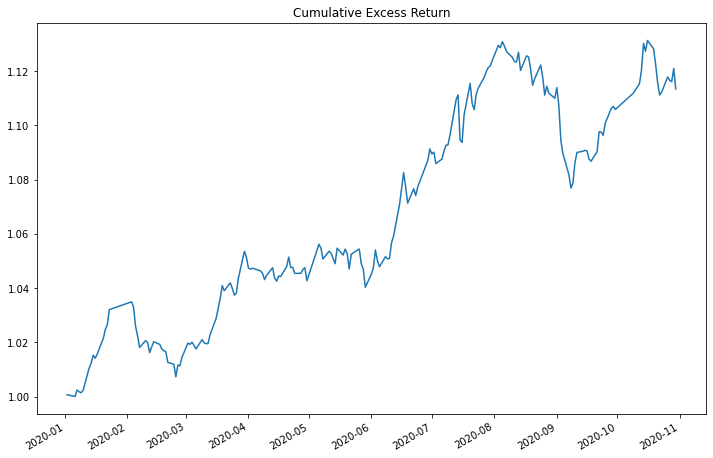

rtn p.a.: 0.13816886499509604
sharpe ratio: 2.1358164959680015


In [58]:
anomaly_name = 'ROADifferenceYoY'
suffix = '0000'
anomaly = pd.read_csv(os.path.join(DATA_ROOT, f'data/payoffs/anomaly/{anomaly_name}.csv'), index_col=0, parse_dates=True)[[f'{anomaly_name}_{suffix}']]
analyse_factor_on_model(anomaly , "FF3", "simplified", START_DATE, END_DATE, regression_length=0)

All Time Correlation


MKT       SMB       HML
ROADifferenceYoY_0001  0.122534 -0.208229 -0.281077

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     ROADifferenceYoY_0001   R-squared:                       0.119
Model:                               OLS   Adj. R-squared:                  0.105
Method:                    Least Squares   F-statistic:                     8.768
Date:                   Wed, 13 Jan 2021   Prob (F-statistic):           1.75e-05
Time:                           17:43:12   Log-Likelihood:                 709.43
No. Observations:                    199   AIC:                            -1411.
Df Residuals:                        195   BIC:                            -1398.
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      1.634      0.104      -0.000       0.002
MKT            0.0087      0.036      0.238      0.812      -0.063       0.081
SMB           -0.1285      0.043     -2.970      0.003      -0.214      -0.043
HML           -0.1237      0.035     -3.578      0.000      -0.192      -0.056
==============================================================================
Omnibus:                        6.414   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.040   Jarque-Bera (JB):                7.698
Skew:                          -0.244   Prob(JB):                       0.0213
Kurtosis:                       3.831   Cond. No.                         90.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

alpha p.a.: 0.18935623872053314


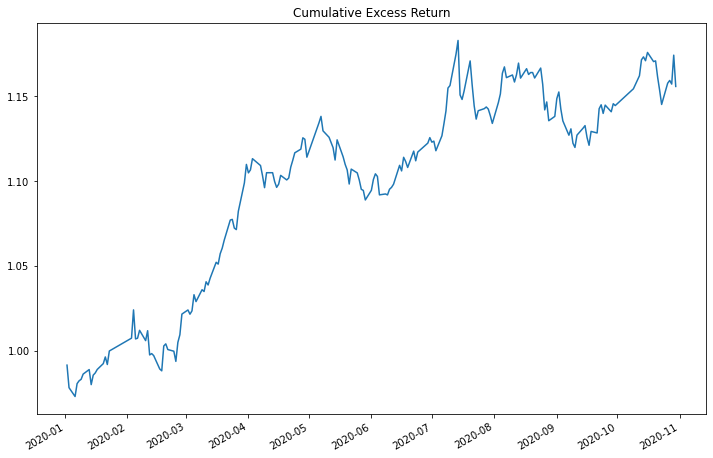

rtn p.a.: 0.189356238720533
sharpe ratio: 1.7376517286030175


In [59]:
anomaly_name = 'ROADifferenceYoY'
suffix = '0001'
anomaly = pd.read_csv(os.path.join(DATA_ROOT, f'data/payoffs/anomaly/{anomaly_name}.csv'), index_col=0, parse_dates=True)[[f'{anomaly_name}_{suffix}']]
analyse_factor_on_model(anomaly , "FF3", "simplified", START_DATE, END_DATE, regression_length=0)

All Time Correlation


MKT       SMB       HML
ROADifferenceYoY_0010  0.245754 -0.305589 -0.433639

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     ROADifferenceYoY_0010   R-squared:                       0.280
Model:                               OLS   Adj. R-squared:                  0.269
Method:                    Least Squares   F-statistic:                     25.33
Date:                   Wed, 13 Jan 2021   Prob (F-statistic):           6.99e-14
Time:                           17:43:17   Log-Likelihood:                 838.70
No. Observations:                    199   AIC:                            -1669.
Df Residuals:                        195   BIC:                            -1656.
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.917      0.057   -1.43e-05       0.001
MKT            0.0271      0.019      1.424      0.156      -0.010       0.065
SMB           -0.1104      0.023     -4.884      0.000      -0.155      -0.066
HML           -0.1025      0.018     -5.677      0.000      -0.138      -0.067
==============================================================================
Omnibus:                        5.332   Durbin-Watson:                   1.655
Prob(Omnibus):                  0.070   Jarque-Bera (JB):                7.647
Skew:                           0.056   Prob(JB):                       0.0218
Kurtosis:                       3.954   Cond. No.                         90.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

alpha p.a.: 0.10998371331412395


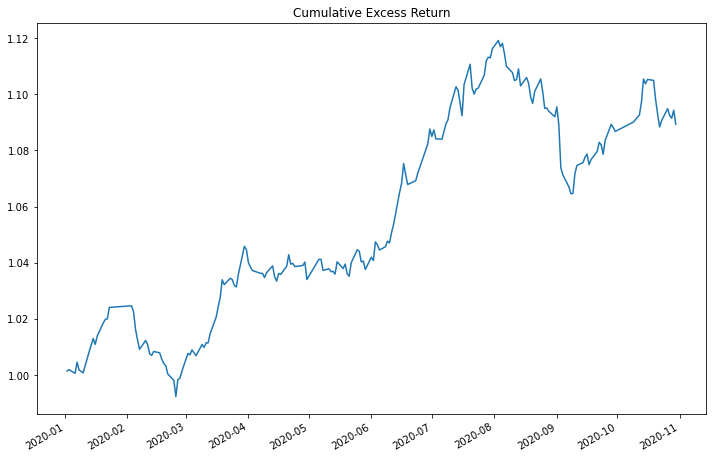

rtn p.a.: 0.10998371331412388
sharpe ratio: 1.9321498199963993


In [60]:
anomaly_name = 'ROADifferenceYoY'
suffix = '0010'
anomaly = pd.read_csv(os.path.join(DATA_ROOT, f'data/payoffs/anomaly/{anomaly_name}.csv'), index_col=0, parse_dates=True)[[f'{anomaly_name}_{suffix}']]
analyse_factor_on_model(anomaly , "FF3", "simplified", START_DATE, END_DATE, regression_length=0)

All Time Correlation


MKT       SMB       HML
ROADifferenceYoY_0011  0.201809 -0.155882 -0.312666

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     ROADifferenceYoY_0011   R-squared:                       0.126
Model:                               OLS   Adj. R-squared:                  0.113
Method:                    Least Squares   F-statistic:                     9.388
Date:                   Wed, 13 Jan 2021   Prob (F-statistic):           7.96e-06
Time:                           17:43:21   Log-Likelihood:                 744.90
No. Observations:                    199   AIC:                            -1482.
Df Residuals:                        195   BIC:                            -1469.
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      1.508      0.133      -0.000       0.001
MKT            0.0388      0.030      1.273      0.205      -0.021       0.099
SMB           -0.0818      0.036     -2.258      0.025      -0.153      -0.010
HML           -0.1040      0.029     -3.596      0.000      -0.161      -0.047
==============================================================================
Omnibus:                        0.447   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.800   Jarque-Bera (JB):                0.356
Skew:                          -0.104   Prob(JB):                        0.837
Kurtosis:                       3.006   Cond. No.                         90.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

alpha p.a.: 0.14272376655952929


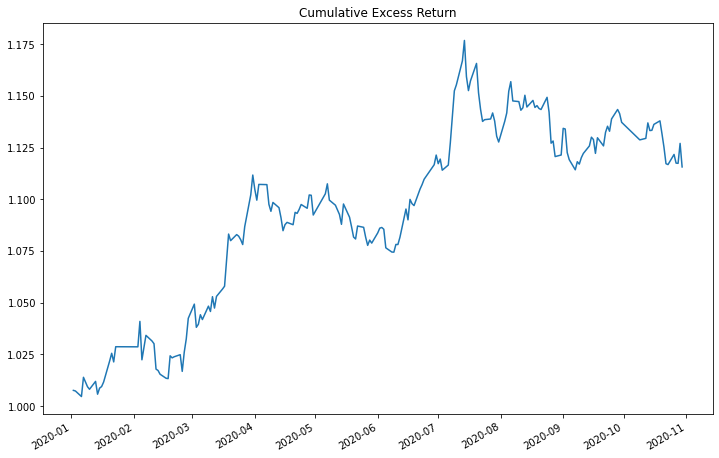

rtn p.a.: 0.14272376655952934
sharpe ratio: 1.5653156508880623


In [61]:
anomaly_name = 'ROADifferenceYoY'
suffix = '0011'
anomaly = pd.read_csv(os.path.join(DATA_ROOT, f'data/payoffs/anomaly/{anomaly_name}.csv'), index_col=0, parse_dates=True)[[f'{anomaly_name}_{suffix}']]
analyse_factor_on_model(anomaly , "FF3", "simplified", START_DATE, END_DATE, regression_length=0)

最好的编制方式是0001, 做市场中性比不做好, 不做行业中性比较好

和ROE的共同点是不做行业中性比较好, 一方面原因是regression可能不太适合, 另一方面可能是因子本身不需要做行业中性. ROE不做市值中性比较好, ROA做市值中性比较好, 这个可能和它们本身自己的SIZE因子暴露不同有关, ROA本身有很负的SMB暴露, 做市值中性可以有效降低负暴露.

#### ORGrowthYoY

All Time Correlation


MKT       SMB       HML
ORGrowthYoY_0000  0.345064 -0.459307 -0.468884

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       ORGrowthYoY_0000   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     53.89
Date:                Wed, 13 Jan 2021   Prob (F-statistic):           2.04e-25
Time:                        18:00:57   Log-Likelihood:                 819.33
No. Observations:                 199   AIC:                            -1631.
Df Residuals:                     195   BIC:                            -1617.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.000      2.278      0.024    8.77e-05       0.001
MKT            0.0755      0.021      3.600      0.000       0.034       0.117
SMB           -0.2146      0.025     -8.616      0.000      -0.264      -0.166
HML           -0.1229      0.020     -6.178      0.000      -0.162      -0.084
==============================================================================
Omnibus:                        3.633   Durbin-Watson:                   1.507
Prob(Omnibus):                  0.163   Jarque-Bera (JB):                3.759
Skew:                           0.154   Prob(JB):                        0.153
Kurtosis:                       3.598   Cond. No.                         90.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

alpha p.a.: 0.14892061582796287


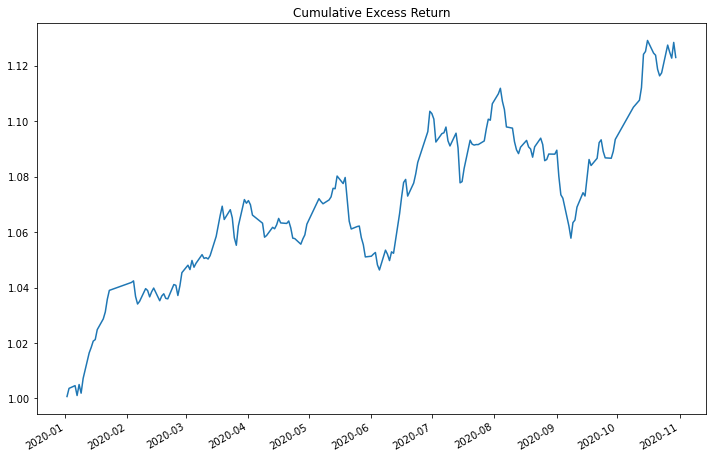

rtn p.a.: 0.14892061582796268
sharpe ratio: 2.374860090959139
All Time Correlation


MKT       SMB       HML
ORGrowthYoY_0010  0.156918 -0.275405 -0.591366

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       ORGrowthYoY_0010   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     47.70
Date:                Wed, 13 Jan 2021   Prob (F-statistic):           3.64e-23
Time:                        18:00:58   Log-Likelihood:                 787.22
No. Observations:                 199   AIC:                            -1566.
Df Residuals:                     195   BIC:                            -1553.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.350      0.179      -0.000       0.001
MKT           -0.0407      0.025     -1.650      0.101      -0.089       0.008
SMB           -0.1340      0.029     -4.579      0.000      -0.192      -0.076
HML           -0.2425      0.023    -10.374      0.000      -0.289      -0.196
==============================================================================
Omnibus:                        1.300   Durbin-Watson:                   1.585
Prob(Omnibus):                  0.522   Jarque-Bera (JB):                0.966
Skew:                           0.141   Prob(JB):                        0.617
Kurtosis:                       3.194   Cond. No.                         90.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

alpha p.a.: 0.098887463843834


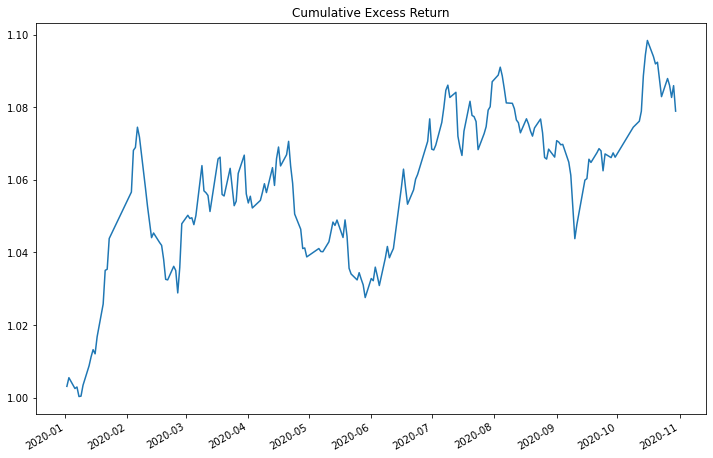

rtn p.a.: 0.09888746384383382
sharpe ratio: 1.3418738190604087
All Time Correlation


MKT      SMB       HML
ORGrowthYoY_0001  0.330403 -0.46705 -0.454703

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       ORGrowthYoY_0001   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     51.96
Date:                Wed, 13 Jan 2021   Prob (F-statistic):           1.00e-24
Time:                        18:00:58   Log-Likelihood:                 753.69
No. Observations:                 199   AIC:                            -1499.
Df Residuals:                     195   BIC:                            -1486.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.300      0.195      -0.000       0.001
MKT            0.0993      0.029      3.403      0.001       0.042       0.157
SMB           -0.3010      0.035     -8.687      0.000      -0.369      -0.233
HML           -0.1648      0.028     -5.955      0.000      -0.219      -0.110
==============================================================================
Omnibus:                        1.512   Durbin-Watson:                   1.922
Prob(Omnibus):                  0.470   Jarque-Bera (JB):                1.382
Skew:                           0.075   Prob(JB):                        0.501
Kurtosis:                       2.620   Cond. No.                         90.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

alpha p.a.: 0.11498391423321898


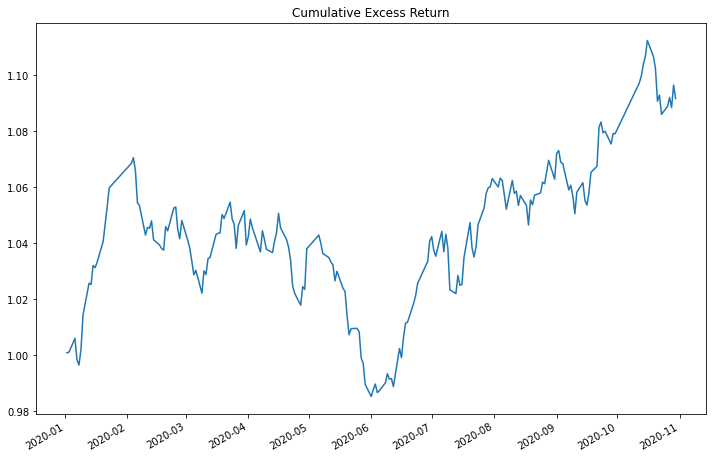

rtn p.a.: 0.11498391423321869
sharpe ratio: 1.318526213694951
All Time Correlation


MKT       SMB       HML
ORGrowthYoY_0011  0.164141 -0.226465 -0.680886

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       ORGrowthYoY_0011   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     70.87
Date:                Wed, 13 Jan 2021   Prob (F-statistic):           4.90e-31
Time:                        18:00:58   Log-Likelihood:                 726.59
No. Observations:                 199   AIC:                            -1445.
Df Residuals:                     195   BIC:                            -1432.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      0.900      0.369      -0.000       0.001
MKT           -0.0864      0.033     -2.584      0.010      -0.152      -0.020
SMB           -0.1559      0.040     -3.927      0.000      -0.234      -0.078
HML           -0.4244      0.032    -13.385      0.000      -0.487      -0.362
==============================================================================
Omnibus:                        9.282   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.010   Jarque-Bera (JB):               15.140
Skew:                          -0.225   Prob(JB):                     0.000516
Kurtosis:                       4.274   Cond. No.                         90.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

alpha p.a.: 0.08796528247003936


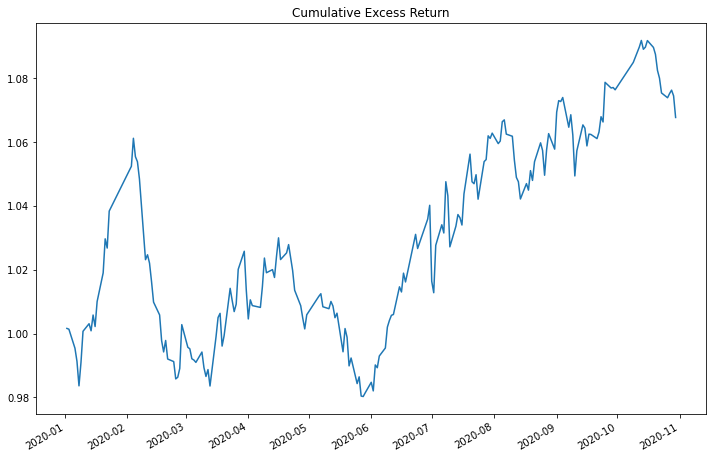

rtn p.a.: 0.08796528247003908
sharpe ratio: 0.8799857522216049


In [67]:
anomaly_name = 'ORGrowthYoY'
suffix = '0000'
anomaly = pd.read_csv(os.path.join(DATA_ROOT, f'data/payoffs/anomaly/{anomaly_name}.csv'), index_col=0, parse_dates=True)[[f'{anomaly_name}_{suffix}']]
analyse_factor_on_model(anomaly , "FF3", "simplified", START_DATE, END_DATE, regression_length=0)

suffix = '0010'
anomaly = pd.read_csv(os.path.join(DATA_ROOT, f'data/payoffs/anomaly/{anomaly_name}.csv'), index_col=0, parse_dates=True)[[f'{anomaly_name}_{suffix}']]
analyse_factor_on_model(anomaly , "FF3", "simplified", START_DATE, END_DATE, regression_length=0)

suffix = '0001'
anomaly = pd.read_csv(os.path.join(DATA_ROOT, f'data/payoffs/anomaly/{anomaly_name}.csv'), index_col=0, parse_dates=True)[[f'{anomaly_name}_{suffix}']]
analyse_factor_on_model(anomaly , "FF3", "simplified", START_DATE, END_DATE, regression_length=0)

suffix = '0011'
anomaly = pd.read_csv(os.path.join(DATA_ROOT, f'data/payoffs/anomaly/{anomaly_name}.csv'), index_col=0, parse_dates=True)[[f'{anomaly_name}_{suffix}']]
analyse_factor_on_model(anomaly , "FF3", "simplified", START_DATE, END_DATE, regression_length=0)

0000编制方式表现最好

#### BrrSGRO

All Time Correlation


MKT       SMB       HML
BrrSGRO_0000  0.083518 -0.504954 -0.401733

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           BrrSGRO_0000   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     44.70
Date:                Wed, 13 Jan 2021   Prob (F-statistic):           4.97e-22
Time:                        18:05:43   Log-Likelihood:                 841.24
No. Observations:                 199   AIC:                            -1674.
Df Residuals:                     195   BIC:                            -1661.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.621e-05      0.000      0.375      0.708      -0.000       0.001
MKT           -0.0219      0.019     -1.167      0.245      -0.059       0.015
SMB           -0.1968      0.022     -8.820      0.000      -0.241      -0.153
HML           -0.1213      0.018     -6.806      0.000      -0.156      -0.086
==============================================================================
Omnibus:                        1.718   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.424   Jarque-Bera (JB):                1.377
Skew:                          -0.105   Prob(JB):                        0.502
Kurtosis:                       3.349   Cond. No.                         90.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

alpha p.a.: 0.008537218180640868


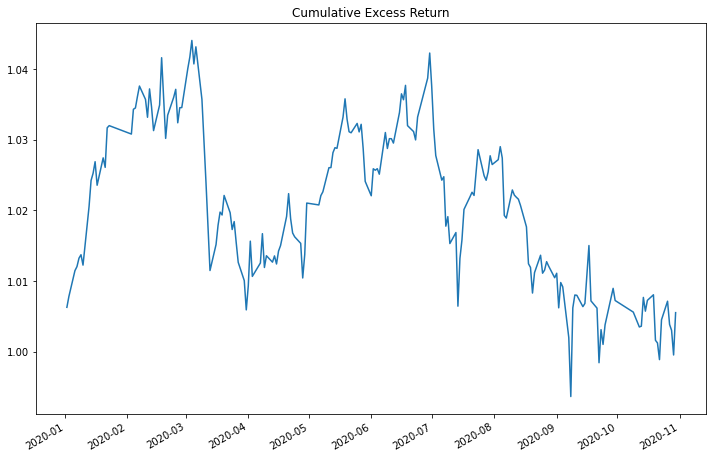

rtn p.a.: 0.008537218180640781
sharpe ratio: 0.1519523199229968
All Time Correlation


MKT       SMB      HML
BrrSGRO_0010  0.050865 -0.600866 -0.29892

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           BrrSGRO_0010   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     51.26
Date:                Wed, 13 Jan 2021   Prob (F-statistic):           1.78e-24
Time:                        18:05:43   Log-Likelihood:                 862.55
No. Observations:                 199   AIC:                            -1717.
Df Residuals:                     195   BIC:                            -1704.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -1.86e-05      0.000     -0.081      0.936      -0.000       0.000
MKT           -0.0141      0.017     -0.833      0.406      -0.047       0.019
SMB           -0.2197      0.020    -10.957      0.000      -0.259      -0.180
HML           -0.0810      0.016     -5.062      0.000      -0.113      -0.049
==============================================================================
Omnibus:                        5.085   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.079   Jarque-Bera (JB):                6.897
Skew:                          -0.090   Prob(JB):                       0.0318
Kurtosis:                       3.894   Cond. No.                         90.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

alpha p.a.: -0.020394086998041294


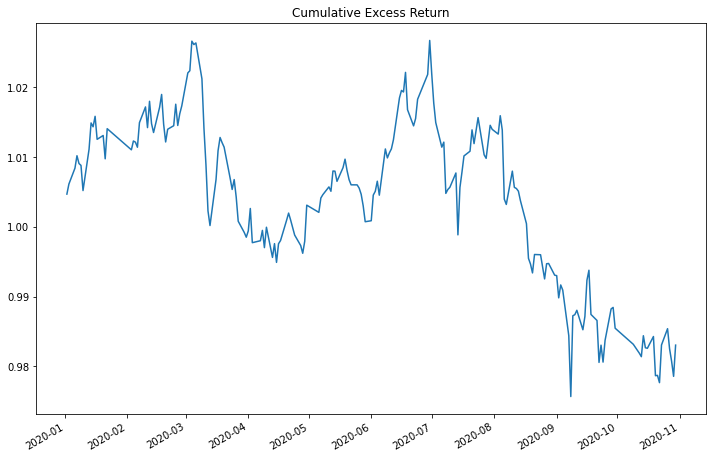

rtn p.a.: -0.020394086998041325
sharpe ratio: -0.4039660041280373
All Time Correlation


MKT      SMB       HML
BrrSGRO_0001  0.041618 -0.33932 -0.555568

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           BrrSGRO_0001   R-squared:                       0.450
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     53.22
Date:                Wed, 13 Jan 2021   Prob (F-statistic):           3.55e-25
Time:                        18:05:44   Log-Likelihood:                 747.99
No. Observations:                 199   AIC:                            -1488.
Df Residuals:                     195   BIC:                            -1475.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.851e-05      0.000     -0.118      0.906      -0.001       0.001
MKT           -0.1108      0.030     -3.693      0.000      -0.170      -0.052
SMB           -0.2058      0.036     -5.773      0.000      -0.276      -0.136
HML           -0.3088      0.028    -10.845      0.000      -0.365      -0.253
==============================================================================
Omnibus:                        2.500   Durbin-Watson:                   1.802
Prob(Omnibus):                  0.286   Jarque-Bera (JB):                2.431
Skew:                          -0.073   Prob(JB):                        0.297
Kurtosis:                       3.522   Cond. No.                         90.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

alpha p.a.: -0.02793348004180342


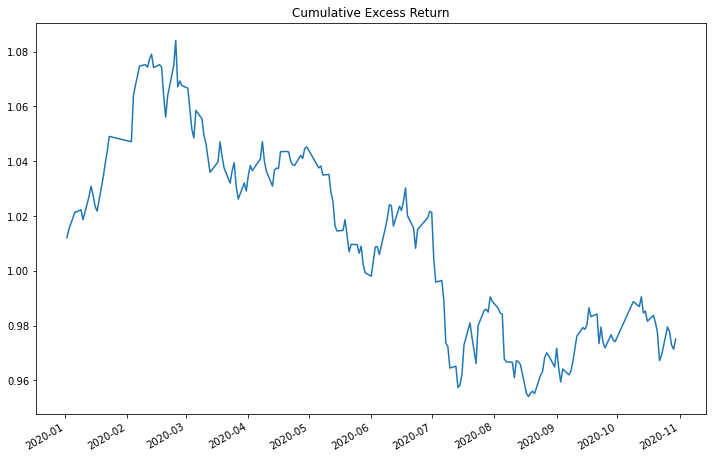

rtn p.a.: -0.027933480041803585
sharpe ratio: -0.3112431189445643
All Time Correlation


MKT       SMB       HML
BrrSGRO_0011  0.050307 -0.365954 -0.526153

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           BrrSGRO_0011   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     48.53
Date:                Wed, 13 Jan 2021   Prob (F-statistic):           1.79e-23
Time:                        18:05:44   Log-Likelihood:                 775.98
No. Observations:                 199   AIC:                            -1544.
Df Residuals:                     195   BIC:                            -1531.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.483e-05      0.000     -0.210      0.834      -0.001       0.001
MKT           -0.0820      0.026     -3.147      0.002      -0.133      -0.031
SMB           -0.1920      0.031     -6.199      0.000      -0.253      -0.131
HML           -0.2454      0.025     -9.919      0.000      -0.294      -0.197
==============================================================================
Omnibus:                        3.686   Durbin-Watson:                   1.929
Prob(Omnibus):                  0.158   Jarque-Bera (JB):                4.391
Skew:                          -0.047   Prob(JB):                        0.111
Kurtosis:                       3.722   Cond. No.                         90.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

alpha p.a.: -0.034565639051518895


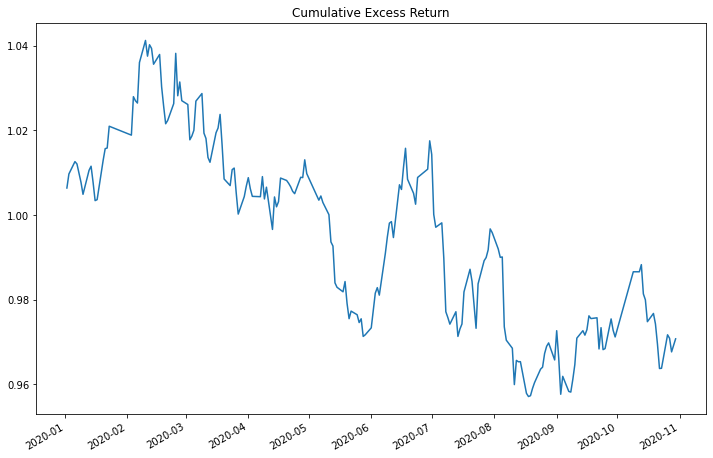

rtn p.a.: -0.03456563905151904
sharpe ratio: -0.4432477040654167


In [68]:
anomaly_name = 'BrrSGRO'
suffix = '0000'
anomaly = pd.read_csv(os.path.join(DATA_ROOT, f'data/payoffs/anomaly/{anomaly_name}.csv'), index_col=0, parse_dates=True)[[f'{anomaly_name}_{suffix}']]
analyse_factor_on_model(anomaly , "FF3", "simplified", START_DATE, END_DATE, regression_length=0)

suffix = '0010'
anomaly = pd.read_csv(os.path.join(DATA_ROOT, f'data/payoffs/anomaly/{anomaly_name}.csv'), index_col=0, parse_dates=True)[[f'{anomaly_name}_{suffix}']]
analyse_factor_on_model(anomaly , "FF3", "simplified", START_DATE, END_DATE, regression_length=0)

suffix = '0001'
anomaly = pd.read_csv(os.path.join(DATA_ROOT, f'data/payoffs/anomaly/{anomaly_name}.csv'), index_col=0, parse_dates=True)[[f'{anomaly_name}_{suffix}']]
analyse_factor_on_model(anomaly , "FF3", "simplified", START_DATE, END_DATE, regression_length=0)

suffix = '0011'
anomaly = pd.read_csv(os.path.join(DATA_ROOT, f'data/payoffs/anomaly/{anomaly_name}.csv'), index_col=0, parse_dates=True)[[f'{anomaly_name}_{suffix}']]
analyse_factor_on_model(anomaly , "FF3", "simplified", START_DATE, END_DATE, regression_length=0)

alpha都为负, 说明该因子至少不是全时刻都有效的

#### NIGrowthYoY

All Time Correlation


MKT       SMB       HML
NIGrowthYoY_0000  0.164593 -0.497524 -0.416976

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       NIGrowthYoY_0000   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     44.87
Date:                Wed, 13 Jan 2021   Prob (F-statistic):           4.28e-22
Time:                        18:11:21   Log-Likelihood:                 866.16
No. Observations:                 199   AIC:                            -1724.
Df Residuals:                     195   BIC:                            -1711.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.161      0.247      -0.000       0.001
MKT            0.0054      0.017      0.324      0.746      -0.027       0.038
SMB           -0.1730      0.020     -8.787      0.000      -0.212      -0.134
HML           -0.1010      0.016     -6.421      0.000      -0.132      -0.070
==============================================================================
Omnibus:                        3.404   Durbin-Watson:                   1.683
Prob(Omnibus):                  0.182   Jarque-Bera (JB):                3.933
Skew:                          -0.033   Prob(JB):                        0.140
Kurtosis:                       3.685   Cond. No.                         90.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

alpha p.a.: 0.050577639203966344


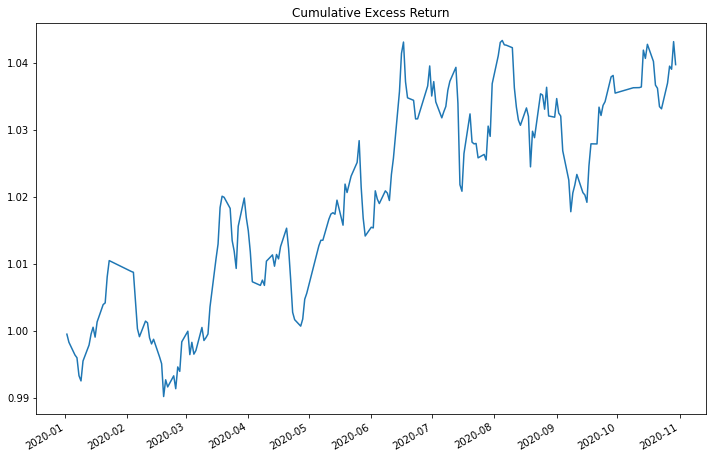

rtn p.a.: 0.050577639203966296
sharpe ratio: 1.0201113285800385
All Time Correlation


MKT       SMB      HML
NIGrowthYoY_0010 -0.124118 -0.410732  0.06009

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       NIGrowthYoY_0010   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     14.32
Date:                Wed, 13 Jan 2021   Prob (F-statistic):           1.79e-08
Time:                        18:11:22   Log-Likelihood:                 756.84
No. Observations:                 199   AIC:                            -1506.
Df Residuals:                     195   BIC:                            -1493.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.634e-05      0.000     -0.220      0.826      -0.001       0.001
MKT           -0.0355      0.029     -1.238      0.217      -0.092       0.021
SMB           -0.2138      0.034     -6.269      0.000      -0.281      -0.147
HML            0.0134      0.027      0.492      0.623      -0.040       0.067
==============================================================================
Omnibus:                        1.223   Durbin-Watson:                   1.861
Prob(Omnibus):                  0.543   Jarque-Bera (JB):                0.874
Skew:                           0.099   Prob(JB):                        0.646
Kurtosis:                       3.257   Cond. No.                         90.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

alpha p.a.: -0.03746586511388801


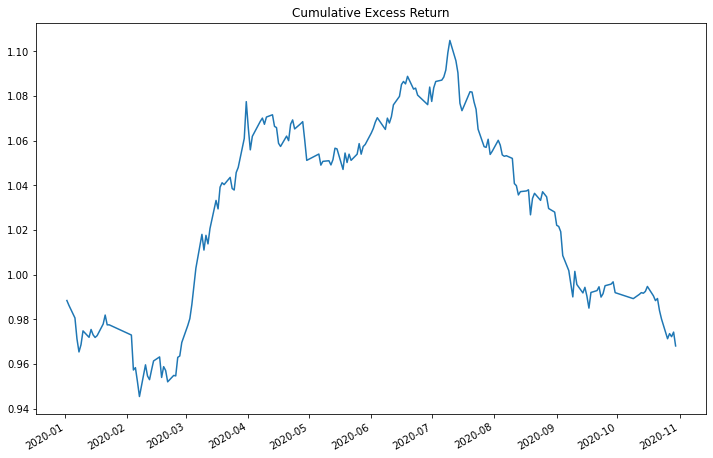

rtn p.a.: -0.03746586511388789
sharpe ratio: -0.4361413761400143
All Time Correlation


MKT       SMB       HML
NIGrowthYoY_0001  0.209901 -0.524225 -0.280292

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       NIGrowthYoY_0001   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     36.93
Date:                Wed, 13 Jan 2021   Prob (F-statistic):           6.02e-19
Time:                        18:11:22   Log-Likelihood:                 756.01
No. Observations:                 199   AIC:                            -1504.
Df Residuals:                     195   BIC:                            -1491.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.504      0.615      -0.001       0.001
MKT            0.0683      0.029      2.369      0.019       0.011       0.125
SMB           -0.3134      0.034     -9.153      0.000      -0.381      -0.246
HML           -0.0855      0.027     -3.126      0.002      -0.139      -0.032
==============================================================================
Omnibus:                        4.318   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.115   Jarque-Bera (JB):                3.914
Skew:                          -0.294   Prob(JB):                        0.141
Kurtosis:                       3.355   Cond. No.                         90.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

alpha p.a.: 0.03440103034330777


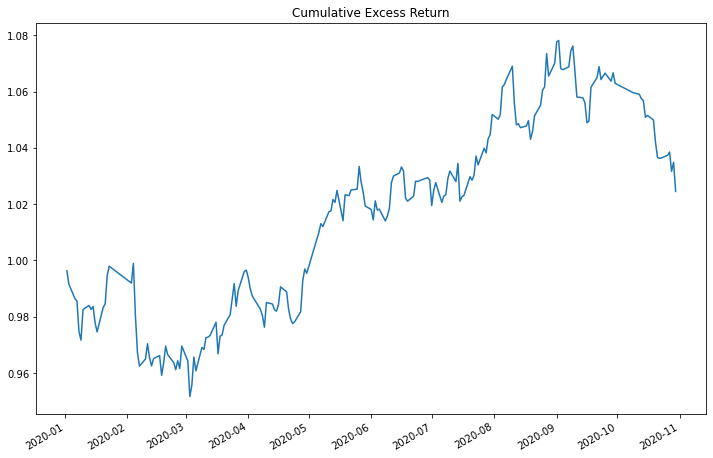

rtn p.a.: 0.034401030343307645
sharpe ratio: 0.398820808402323
All Time Correlation


MKT       SMB       HML
NIGrowthYoY_0011 -0.122592 -0.445278  0.091572

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       NIGrowthYoY_0011   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     17.63
Date:                Wed, 13 Jan 2021   Prob (F-statistic):           3.64e-10
Time:                        18:11:22   Log-Likelihood:                 700.89
No. Observations:                 199   AIC:                            -1394.
Df Residuals:                     195   BIC:                            -1381.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.455e-05      0.001      0.028      0.978      -0.001       0.001
MKT           -0.0365      0.038     -0.961      0.338      -0.112       0.038
SMB           -0.3152      0.045     -6.978      0.000      -0.404      -0.226
HML            0.0396      0.036      1.097      0.274      -0.032       0.111
==============================================================================
Omnibus:                        0.638   Durbin-Watson:                   2.113
Prob(Omnibus):                  0.727   Jarque-Bera (JB):                0.752
Skew:                           0.053   Prob(JB):                        0.686
Kurtosis:                       2.718   Cond. No.                         90.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

alpha p.a.: -0.012040291412840822


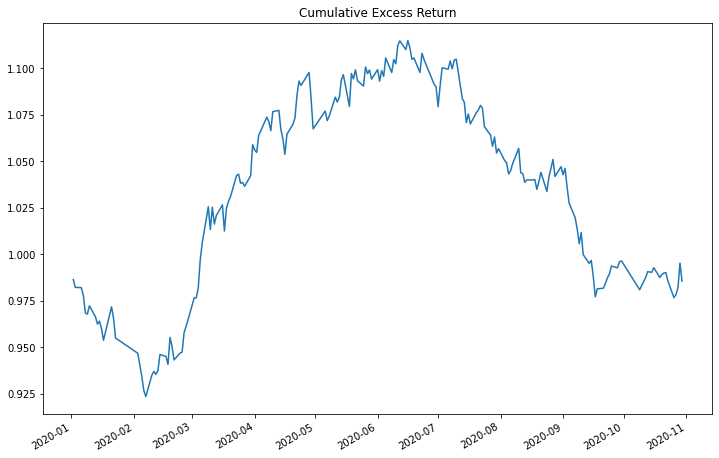

rtn p.a.: -0.012040291412840753
sharpe ratio: -0.1058199030018638


In [69]:
anomaly_name = 'NIGrowthYoY'
suffix = '0000'
anomaly = pd.read_csv(os.path.join(DATA_ROOT, f'data/payoffs/anomaly/{anomaly_name}.csv'), index_col=0, parse_dates=True)[[f'{anomaly_name}_{suffix}']]
analyse_factor_on_model(anomaly , "FF3", "simplified", START_DATE, END_DATE, regression_length=0)

suffix = '0010'
anomaly = pd.read_csv(os.path.join(DATA_ROOT, f'data/payoffs/anomaly/{anomaly_name}.csv'), index_col=0, parse_dates=True)[[f'{anomaly_name}_{suffix}']]
analyse_factor_on_model(anomaly , "FF3", "simplified", START_DATE, END_DATE, regression_length=0)

suffix = '0001'
anomaly = pd.read_csv(os.path.join(DATA_ROOT, f'data/payoffs/anomaly/{anomaly_name}.csv'), index_col=0, parse_dates=True)[[f'{anomaly_name}_{suffix}']]
analyse_factor_on_model(anomaly , "FF3", "simplified", START_DATE, END_DATE, regression_length=0)

suffix = '0011'
anomaly = pd.read_csv(os.path.join(DATA_ROOT, f'data/payoffs/anomaly/{anomaly_name}.csv'), index_col=0, parse_dates=True)[[f'{anomaly_name}_{suffix}']]
analyse_factor_on_model(anomaly , "FF3", "simplified", START_DATE, END_DATE, regression_length=0)

#### NIGrowthQoQ

All Time Correlation


MKT       SMB       HML
NIGrowthQoQ_0000  0.062806 -0.541225 -0.196721

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       NIGrowthQoQ_0000   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     31.31
Date:                Wed, 13 Jan 2021   Prob (F-statistic):           1.45e-16
Time:                        18:11:44   Log-Likelihood:                 940.60
No. Observations:                 199   AIC:                            -1873.
Df Residuals:                     195   BIC:                            -1860.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.792      0.075   -2.82e-05       0.001
MKT            0.0026      0.011      0.228      0.820      -0.020       0.025
SMB           -0.1231      0.014     -9.087      0.000      -0.150      -0.096
HML           -0.0286      0.011     -2.644      0.009      -0.050      -0.007
==============================================================================
Omnibus:                        0.854   Durbin-Watson:                   1.889
Prob(Omnibus):                  0.653   Jarque-Bera (JB):                0.974
Skew:                           0.130   Prob(JB):                        0.614
Kurtosis:                       2.776   Cond. No.                         90.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

alpha p.a.: 0.05467846220914538


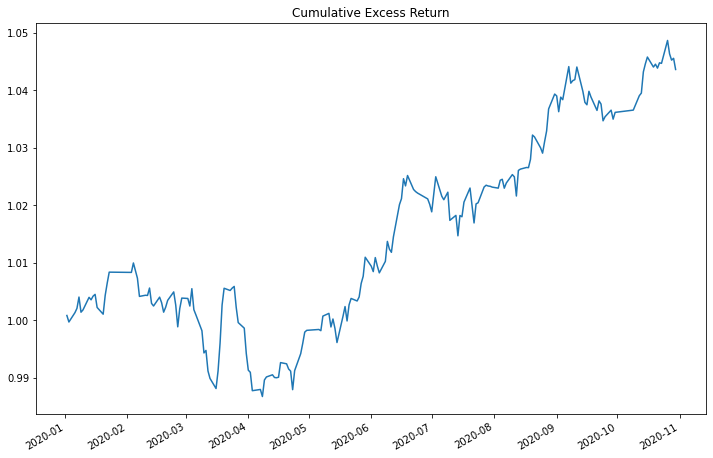

rtn p.a.: 0.054678462209145365
sharpe ratio: 1.6029384185473092
All Time Correlation


MKT       SMB      HML
NIGrowthQoQ_0010  0.186417 -0.060779 -0.20365

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       NIGrowthQoQ_0010   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     3.952
Date:                Wed, 13 Jan 2021   Prob (F-statistic):            0.00915
Time:                        18:11:44   Log-Likelihood:                 826.46
No. Observations:                 199   AIC:                            -1645.
Df Residuals:                     195   BIC:                            -1632.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.000     -0.831      0.407      -0.001       0.000
MKT            0.0331      0.020      1.635      0.104      -0.007       0.073
SMB           -0.0214      0.024     -0.889      0.375      -0.069       0.026
HML           -0.0367      0.019     -1.912      0.057      -0.075       0.001
==============================================================================
Omnibus:                        7.880   Durbin-Watson:                   1.808
Prob(Omnibus):                  0.019   Jarque-Bera (JB):               10.161
Skew:                          -0.276   Prob(JB):                      0.00622
Kurtosis:                       3.959   Cond. No.                         90.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

alpha p.a.: -0.07361725631956555


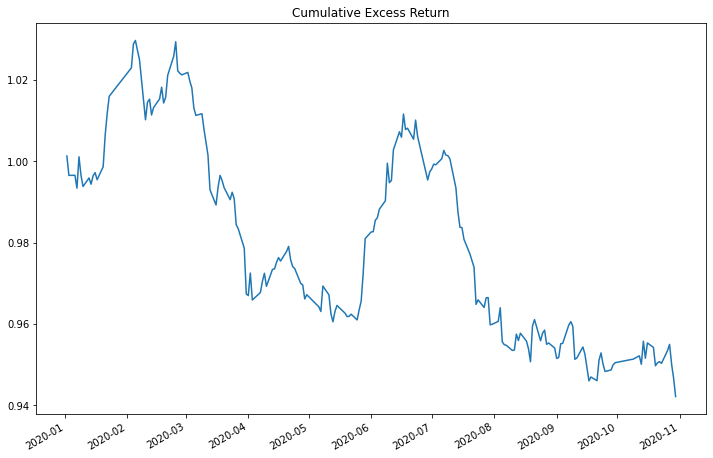

rtn p.a.: -0.07361725631956563
sharpe ratio: -1.2162379600049245
All Time Correlation


MKT      SMB       HML
NIGrowthQoQ_0001  0.065118 -0.42887  0.071857

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       NIGrowthQoQ_0001   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.198
Method:                 Least Squares   F-statistic:                     17.28
Date:                Wed, 13 Jan 2021   Prob (F-statistic):           5.42e-10
Time:                        18:11:44   Log-Likelihood:                 768.83
No. Observations:                 199   AIC:                            -1530.
Df Residuals:                     195   BIC:                            -1516.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.000      3.437      0.001       0.001       0.002
MKT            0.0581      0.027      2.148      0.033       0.005       0.111
SMB           -0.2220      0.032     -6.913      0.000      -0.285      -0.159
HML            0.0551      0.026      2.148      0.033       0.005       0.106
==============================================================================
Omnibus:                       15.628   Durbin-Watson:                   1.922
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.718
Skew:                           0.548   Prob(JB):                     5.23e-05
Kurtosis:                       4.085   Cond. No.                         90.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

alpha p.a.: 0.3044134105818399


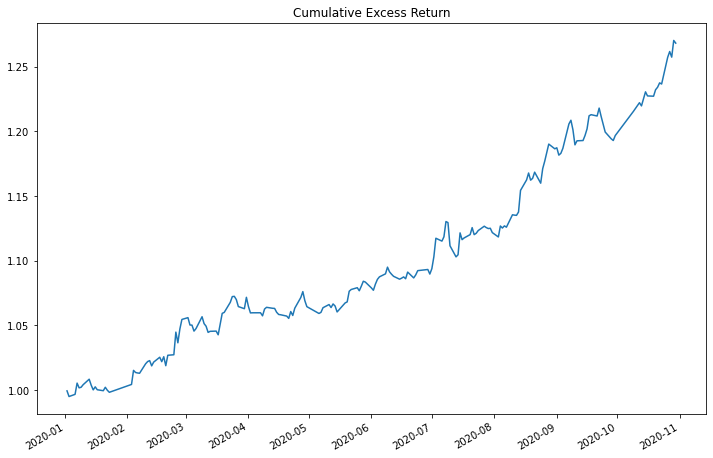

rtn p.a.: 0.30441341058184007
sharpe ratio: 3.7661542320631307
All Time Correlation


MKT       SMB       HML
NIGrowthQoQ_0011  0.292826 -0.166694 -0.134799

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       NIGrowthQoQ_0011   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     8.744
Date:                Wed, 13 Jan 2021   Prob (F-statistic):           1.81e-05
Time:                        18:11:45   Log-Likelihood:                 702.05
No. Observations:                 199   AIC:                            -1396.
Df Residuals:                     195   BIC:                            -1383.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.001      0.270      0.787      -0.001       0.001
MKT            0.1530      0.038      4.048      0.000       0.078       0.228
SMB           -0.1208      0.045     -2.691      0.008      -0.209      -0.032
HML            0.0004      0.036      0.012      0.990      -0.070       0.071
==============================================================================
Omnibus:                        5.948   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.051   Jarque-Bera (JB):                6.023
Skew:                          -0.305   Prob(JB):                       0.0492
Kurtosis:                       3.595   Cond. No.                         90.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

alpha p.a.: 0.019510675296609516


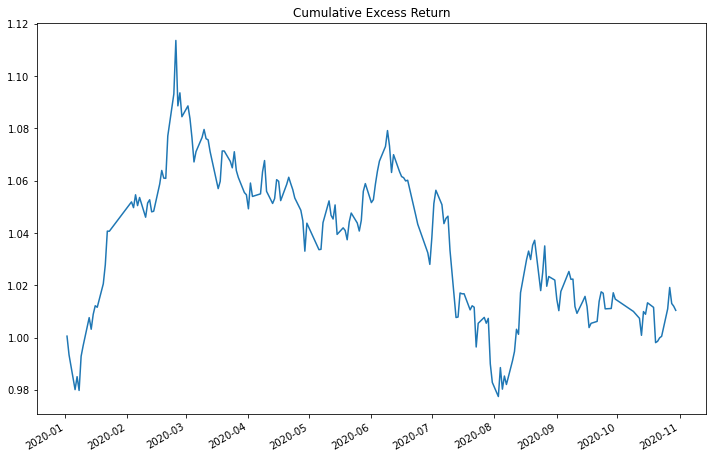

rtn p.a.: 0.01951067529660936
sharpe ratio: 0.1725463327275639


In [70]:
anomaly_name = 'NIGrowthQoQ'
suffix = '0000'
anomaly = pd.read_csv(os.path.join(DATA_ROOT, f'data/payoffs/anomaly/{anomaly_name}.csv'), index_col=0, parse_dates=True)[[f'{anomaly_name}_{suffix}']]
analyse_factor_on_model(anomaly , "FF3", "simplified", START_DATE, END_DATE, regression_length=0)

suffix = '0010'
anomaly = pd.read_csv(os.path.join(DATA_ROOT, f'data/payoffs/anomaly/{anomaly_name}.csv'), index_col=0, parse_dates=True)[[f'{anomaly_name}_{suffix}']]
analyse_factor_on_model(anomaly , "FF3", "simplified", START_DATE, END_DATE, regression_length=0)

suffix = '0001'
anomaly = pd.read_csv(os.path.join(DATA_ROOT, f'data/payoffs/anomaly/{anomaly_name}.csv'), index_col=0, parse_dates=True)[[f'{anomaly_name}_{suffix}']]
analyse_factor_on_model(anomaly , "FF3", "simplified", START_DATE, END_DATE, regression_length=0)

suffix = '0011'
anomaly = pd.read_csv(os.path.join(DATA_ROOT, f'data/payoffs/anomaly/{anomaly_name}.csv'), index_col=0, parse_dates=True)[[f'{anomaly_name}_{suffix}']]
analyse_factor_on_model(anomaly , "FF3", "simplified", START_DATE, END_DATE, regression_length=0)

NIGrowthQoQ 如果不做市值中性的话表现都比较稳定, 而且做了行业中性表现很吓人

#### OCFGrowthYoY

All Time Correlation


MKT      SMB       HML
OCFGrowthYoY_0000 -0.083646 -0.29394 -0.175225

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      OCFGrowthYoY_0000   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     10.42
Date:                Wed, 13 Jan 2021   Prob (F-statistic):           2.16e-06
Time:                        18:23:50   Log-Likelihood:                 926.53
No. Observations:                 199   AIC:                            -1845.
Df Residuals:                     195   BIC:                            -1832.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.000     -1.182      0.239      -0.001       0.000
MKT           -0.0287      0.012     -2.349      0.020      -0.053      -0.005
SMB           -0.0605      0.015     -4.162      0.000      -0.089      -0.032
HML           -0.0379      0.012     -3.260      0.001      -0.061      -0.015
==============================================================================
Omnibus:                        4.986   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.083   Jarque-Bera (JB):                5.159
Skew:                          -0.243   Prob(JB):                       0.0758
Kurtosis:                       3.621   Cond. No.                         90.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

alpha p.a.: -0.06555436380876149


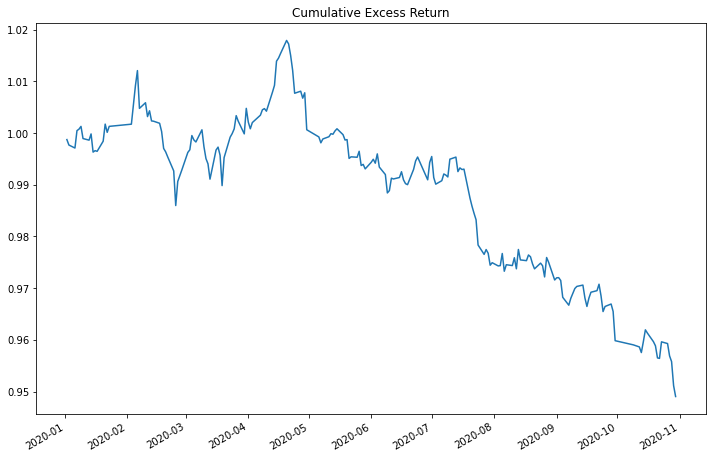

rtn p.a.: -0.06555436380876149
sharpe ratio: -1.7905517310952281
All Time Correlation


MKT       SMB       HML
OCFGrowthYoY_0010 -0.034691 -0.212133 -0.108907

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      OCFGrowthYoY_0010   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     4.232
Date:                Wed, 13 Jan 2021   Prob (F-statistic):            0.00633
Time:                        18:23:51   Log-Likelihood:                 818.44
No. Observations:                 199   AIC:                            -1629.
Df Residuals:                     195   BIC:                            -1616.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9.256e-05      0.000     -0.321      0.748      -0.001       0.000
MKT           -0.0230      0.021     -1.093      0.276      -0.065       0.019
SMB           -0.0731      0.025     -2.923      0.004      -0.122      -0.024
HML           -0.0359      0.020     -1.796      0.074      -0.075       0.004
==============================================================================
Omnibus:                        7.230   Durbin-Watson:                   2.103
Prob(Omnibus):                  0.027   Jarque-Bera (JB):                9.119
Skew:                          -0.258   Prob(JB):                       0.0105
Kurtosis:                       3.913   Cond. No.                         90.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

alpha p.a.: -0.039033785178735986


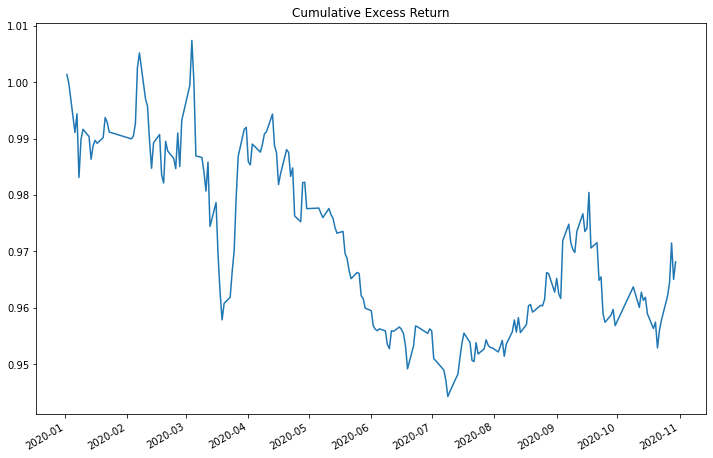

rtn p.a.: -0.03903378517873597
sharpe ratio: -0.6196574978607142
All Time Correlation


MKT       SMB       HML
OCFGrowthYoY_0001 -0.276117 -0.107072 -0.036964

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      OCFGrowthYoY_0001   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     8.270
Date:                Wed, 13 Jan 2021   Prob (F-statistic):           3.31e-05
Time:                        18:23:51   Log-Likelihood:                 786.02
No. Observations:                 199   AIC:                            -1564.
Df Residuals:                     195   BIC:                            -1551.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.000     -0.653      0.515      -0.001       0.000
MKT           -0.1164      0.025     -4.695      0.000      -0.165      -0.068
SMB           -0.0365      0.029     -1.239      0.217      -0.095       0.022
HML           -0.0582      0.024     -2.474      0.014      -0.105      -0.012
==============================================================================
Omnibus:                        1.636   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.441   Jarque-Bera (JB):                1.341
Skew:                          -0.055   Prob(JB):                        0.512
Kurtosis:                       3.387   Cond. No.                         90.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

alpha p.a.: -0.07145351074323922


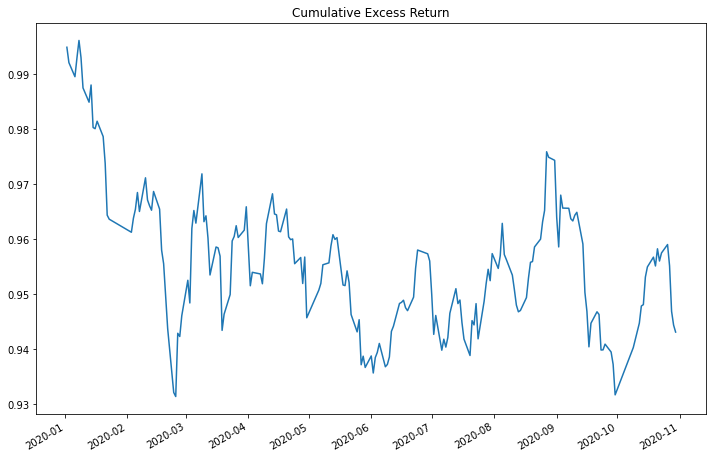

rtn p.a.: -0.07145351074323911
sharpe ratio: -0.9634474748146421
All Time Correlation


MKT       SMB       HML
OCFGrowthYoY_0011 -0.14311  0.014607 -0.138131

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      OCFGrowthYoY_0011   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     4.932
Date:                Wed, 13 Jan 2021   Prob (F-statistic):            0.00253
Time:                        18:23:51   Log-Likelihood:                 678.35
No. Observations:                 199   AIC:                            -1349.
Df Residuals:                     195   BIC:                            -1336.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.001     -0.878      0.381      -0.002       0.001
MKT           -0.1394      0.043     -3.274      0.001      -0.223      -0.055
SMB            0.0256      0.051      0.506      0.613      -0.074       0.125
HML           -0.1303      0.040     -3.225      0.001      -0.210      -0.051
==============================================================================
Omnibus:                       10.654   Durbin-Watson:                   2.127
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               17.271
Skew:                          -0.283   Prob(JB):                     0.000178
Kurtosis:                       4.328   Cond. No.                         90.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

alpha p.a.: -0.1444995897035688


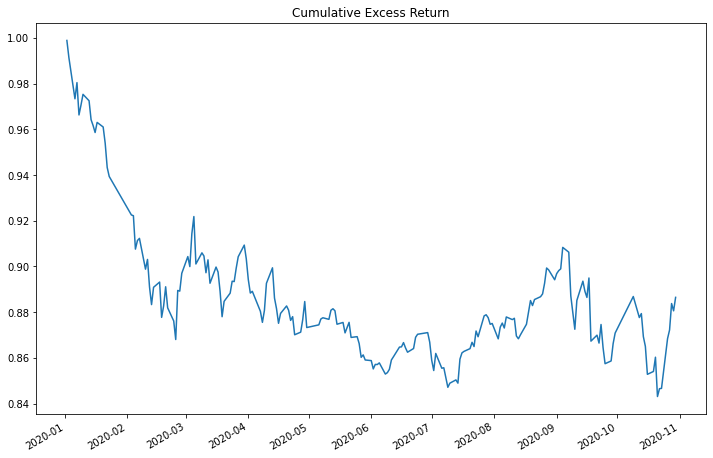

rtn p.a.: -0.1444995897035688
sharpe ratio: -1.1342897622093735


In [71]:
anomaly_name = 'OCFGrowthYoY'
suffix = '0000'
anomaly = pd.read_csv(os.path.join(DATA_ROOT, f'data/payoffs/anomaly/{anomaly_name}.csv'), index_col=0, parse_dates=True)[[f'{anomaly_name}_{suffix}']]
analyse_factor_on_model(anomaly , "FF3", "simplified", START_DATE, END_DATE, regression_length=0)

suffix = '0010'
anomaly = pd.read_csv(os.path.join(DATA_ROOT, f'data/payoffs/anomaly/{anomaly_name}.csv'), index_col=0, parse_dates=True)[[f'{anomaly_name}_{suffix}']]
analyse_factor_on_model(anomaly , "FF3", "simplified", START_DATE, END_DATE, regression_length=0)

suffix = '0001'
anomaly = pd.read_csv(os.path.join(DATA_ROOT, f'data/payoffs/anomaly/{anomaly_name}.csv'), index_col=0, parse_dates=True)[[f'{anomaly_name}_{suffix}']]
analyse_factor_on_model(anomaly , "FF3", "simplified", START_DATE, END_DATE, regression_length=0)

suffix = '0011'
anomaly = pd.read_csv(os.path.join(DATA_ROOT, f'data/payoffs/anomaly/{anomaly_name}.csv'), index_col=0, parse_dates=True)[[f'{anomaly_name}_{suffix}']]
analyse_factor_on_model(anomaly , "FF3", "simplified", START_DATE, END_DATE, regression_length=0)

#### BrrEGRO

All Time Correlation


MKT      SMB       HML
BrrEGRO_0000  0.117732  0.23689 -0.156112

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           BrrEGRO_0000   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     6.006
Date:                Wed, 13 Jan 2021   Prob (F-statistic):           0.000620
Time:                        18:24:19   Log-Likelihood:                 902.87
No. Observations:                 199   AIC:                            -1798.
Df Residuals:                     195   BIC:                            -1785.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.991e-05      0.000      0.212      0.832      -0.000       0.000
MKT            0.0079      0.014      0.574      0.567      -0.019       0.035
SMB            0.0571      0.016      3.486      0.001       0.025       0.089
HML           -0.0250      0.013     -1.912      0.057      -0.051       0.001
==============================================================================
Omnibus:                        0.349   Durbin-Watson:                   1.702
Prob(Omnibus):                  0.840   Jarque-Bera (JB):                0.166
Skew:                           0.057   Prob(JB):                        0.920
Kurtosis:                       3.084   Cond. No.                         90.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

alpha p.a.: -0.005649407284505035


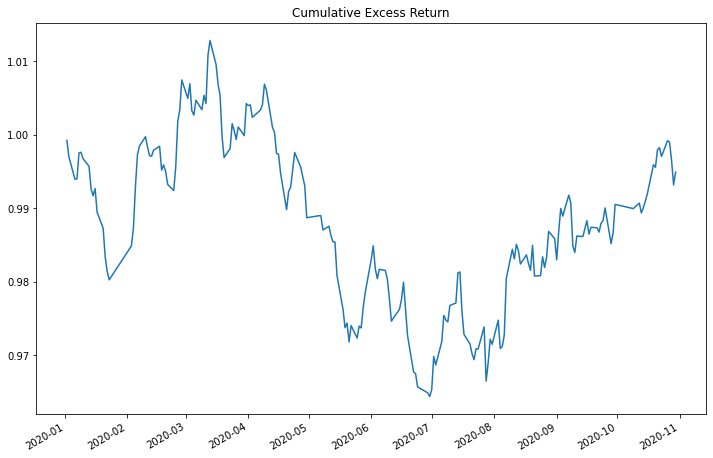

rtn p.a.: -0.005649407284505084
sharpe ratio: -0.13712314273338305
All Time Correlation


MKT       SMB       HML
BrrEGRO_0010 -0.06927 -0.222929  0.086435

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           BrrEGRO_0010   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     4.069
Date:                Wed, 13 Jan 2021   Prob (F-statistic):            0.00784
Time:                        18:24:19   Log-Likelihood:                 796.41
No. Observations:                 199   AIC:                            -1585.
Df Residuals:                     195   BIC:                            -1572.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      0.970      0.333      -0.000       0.001
MKT           -0.0067      0.024     -0.286      0.775      -0.053       0.040
SMB           -0.0901      0.028     -3.224      0.001      -0.145      -0.035
HML            0.0245      0.022      1.096      0.275      -0.020       0.068
==============================================================================
Omnibus:                        6.792   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.034   Jarque-Bera (JB):                7.729
Skew:                           0.286   Prob(JB):                       0.0210
Kurtosis:                       3.778   Cond. No.                         90.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

alpha p.a.: 0.06293792413105417


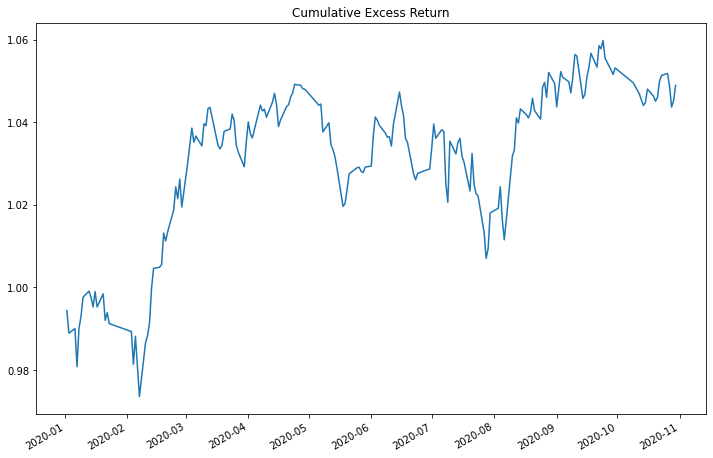

rtn p.a.: 0.06293792413105422
sharpe ratio: 0.8942732622719409
All Time Correlation


MKT       SMB       HML
BrrEGRO_0001 -0.25271  0.417803 -0.165931

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           BrrEGRO_0001   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     36.31
Date:                Wed, 13 Jan 2021   Prob (F-statistic):           1.09e-18
Time:                        18:24:19   Log-Likelihood:                 715.86
No. Observations:                 199   AIC:                            -1424.
Df Residuals:                     195   BIC:                            -1411.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.000     -1.094      0.275      -0.001       0.000
MKT           -0.2393      0.035     -6.785      0.000      -0.309      -0.170
SMB            0.3285      0.042      7.840      0.000       0.246       0.411
HML           -0.1927      0.033     -5.759      0.000      -0.259      -0.127
==============================================================================
Omnibus:                       10.988   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               13.378
Skew:                          -0.416   Prob(JB):                      0.00124
Kurtosis:                       3.959   Cond. No.                         90.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

alpha p.a.: -0.14862165806133817


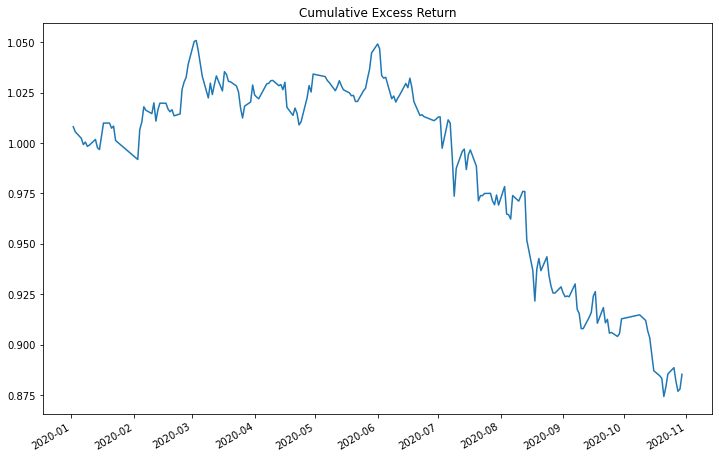

rtn p.a.: -0.14862165806133804
sharpe ratio: -1.4085852287918834
All Time Correlation


MKT      SMB       HML
BrrEGRO_0011 -0.049949 -0.16434  0.207267

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           BrrEGRO_0011   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     5.299
Date:                Wed, 13 Jan 2021   Prob (F-statistic):            0.00156
Time:                        18:24:20   Log-Likelihood:                 676.31
No. Observations:                 199   AIC:                            -1345.
Df Residuals:                     195   BIC:                            -1331.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      1.385      0.167      -0.000       0.002
MKT            0.0346      0.043      0.803      0.423      -0.050       0.119
SMB           -0.1297      0.051     -2.538      0.012      -0.231      -0.029
HML            0.1280      0.041      3.135      0.002       0.047       0.208
==============================================================================
Omnibus:                        9.459   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               13.215
Skew:                           0.303   Prob(JB):                      0.00135
Kurtosis:                       4.107   Cond. No.                         90.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

alpha p.a.: 0.18970251424031304


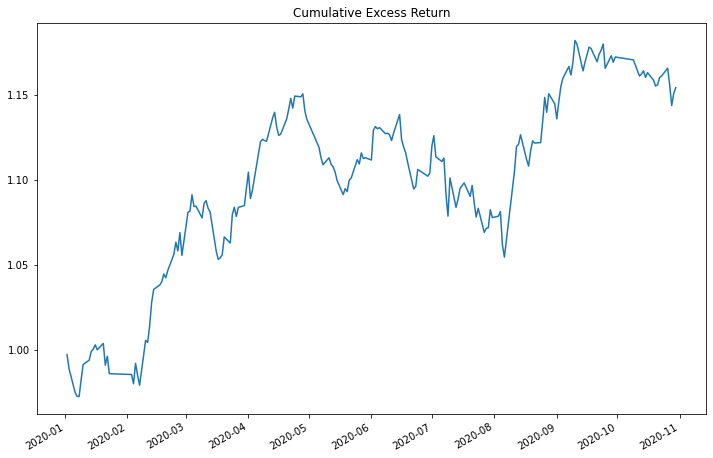

rtn p.a.: 0.18970251424031317
sharpe ratio: 1.4740319624187437


In [72]:
anomaly_name = 'BrrEGRO'
suffix = '0000'
anomaly = pd.read_csv(os.path.join(DATA_ROOT, f'data/payoffs/anomaly/{anomaly_name}.csv'), index_col=0, parse_dates=True)[[f'{anomaly_name}_{suffix}']]
analyse_factor_on_model(anomaly , "FF3", "simplified", START_DATE, END_DATE, regression_length=0)

suffix = '0010'
anomaly = pd.read_csv(os.path.join(DATA_ROOT, f'data/payoffs/anomaly/{anomaly_name}.csv'), index_col=0, parse_dates=True)[[f'{anomaly_name}_{suffix}']]
analyse_factor_on_model(anomaly , "FF3", "simplified", START_DATE, END_DATE, regression_length=0)

suffix = '0001'
anomaly = pd.read_csv(os.path.join(DATA_ROOT, f'data/payoffs/anomaly/{anomaly_name}.csv'), index_col=0, parse_dates=True)[[f'{anomaly_name}_{suffix}']]
analyse_factor_on_model(anomaly , "FF3", "simplified", START_DATE, END_DATE, regression_length=0)

suffix = '0011'
anomaly = pd.read_csv(os.path.join(DATA_ROOT, f'data/payoffs/anomaly/{anomaly_name}.csv'), index_col=0, parse_dates=True)[[f'{anomaly_name}_{suffix}']]
analyse_factor_on_model(anomaly , "FF3", "simplified", START_DATE, END_DATE, regression_length=0)

做了行业中性之后表现还可以, 如果用市值中性的话不错

#### ORGrowthQoQ

All Time Correlation


MKT       SMB      HML
ORGrowthQoQ_0000  0.291162 -0.001882 -0.37272

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       ORGrowthQoQ_0000   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     12.38
Date:                Wed, 13 Jan 2021   Prob (F-statistic):           1.90e-07
Time:                        18:29:59   Log-Likelihood:                 819.67
No. Observations:                 199   AIC:                            -1631.
Df Residuals:                     195   BIC:                            -1618.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.675      0.096   -8.51e-05       0.001
MKT            0.0462      0.021      2.207      0.029       0.005       0.087
SMB            0.0001      0.025      0.006      0.995      -0.049       0.049
HML           -0.0829      0.020     -4.172      0.000      -0.122      -0.044
==============================================================================
Omnibus:                        6.722   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.035   Jarque-Bera (JB):               10.272
Skew:                          -0.128   Prob(JB):                      0.00588
Kurtosis:                       4.083   Cond. No.                         90.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

alpha p.a.: 0.1051210217805783


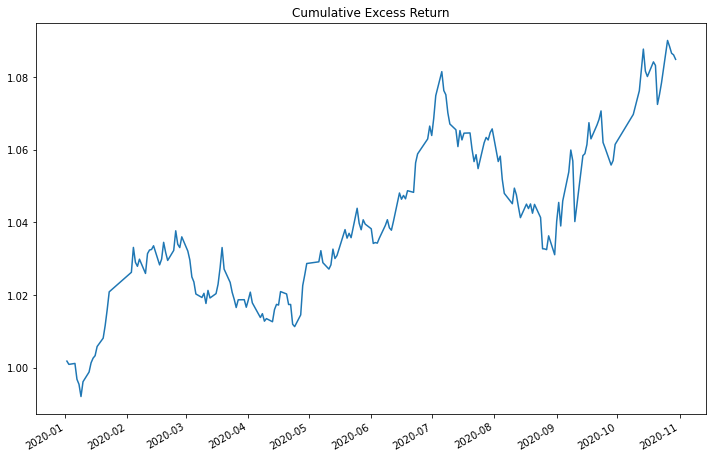

rtn p.a.: 0.1051210217805782
sharpe ratio: 1.6788118822486369
All Time Correlation


MKT      SMB       HML
ORGrowthQoQ_0010  0.059334 -0.13509 -0.263181

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       ORGrowthQoQ_0010   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     6.258
Date:                Wed, 13 Jan 2021   Prob (F-statistic):           0.000446
Time:                        18:29:59   Log-Likelihood:                 788.22
No. Observations:                 199   AIC:                            -1568.
Df Residuals:                     195   BIC:                            -1555.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.565      0.119      -0.000       0.001
MKT           -0.0182      0.025     -0.742      0.459      -0.067       0.030
SMB           -0.0522      0.029     -1.792      0.075      -0.110       0.005
HML           -0.0868      0.023     -3.734      0.000      -0.133      -0.041
==============================================================================
Omnibus:                        3.785   Durbin-Watson:                   1.787
Prob(Omnibus):                  0.151   Jarque-Bera (JB):                4.472
Skew:                           0.074   Prob(JB):                        0.107
Kurtosis:                       3.719   Cond. No.                         90.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

alpha p.a.: 0.11651620461181107


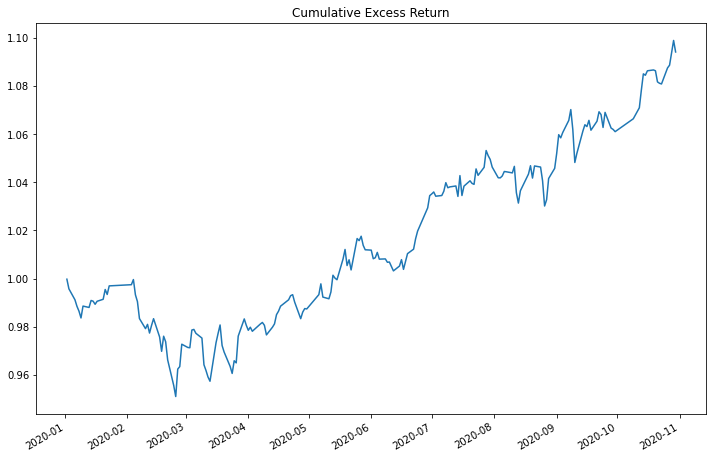

rtn p.a.: 0.116516204611811
sharpe ratio: 1.5884458019357244
All Time Correlation


MKT       SMB       HML
ORGrowthQoQ_0001  0.149563 -0.141131 -0.224346

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       ORGrowthQoQ_0001   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     5.112
Date:                Wed, 13 Jan 2021   Prob (F-statistic):            0.00200
Time:                        18:29:59   Log-Likelihood:                 669.98
No. Observations:                 199   AIC:                            -1332.
Df Residuals:                     195   BIC:                            -1319.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.191e-05      0.001      0.053      0.958      -0.001       0.001
MKT            0.0441      0.044      0.993      0.322      -0.044       0.132
SMB           -0.1058      0.053     -2.004      0.046      -0.210      -0.002
HML           -0.1031      0.042     -2.446      0.015      -0.186      -0.020
==============================================================================
Omnibus:                       15.381   Durbin-Watson:                   1.678
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.728
Skew:                          -0.590   Prob(JB):                     0.000141
Kurtosis:                       3.865   Cond. No.                         90.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

alpha p.a.: -0.007665311019618731


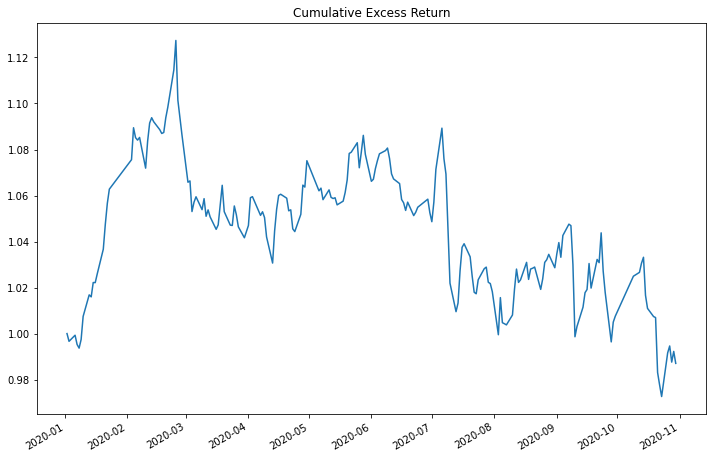

rtn p.a.: -0.007665311019618882
sharpe ratio: -0.057695633253821106
All Time Correlation


MKT       SMB       HML
ORGrowthQoQ_0011  0.073806 -0.326543 -0.243677

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       ORGrowthQoQ_0011   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     12.48
Date:                Wed, 13 Jan 2021   Prob (F-statistic):           1.69e-07
Time:                        18:30:00   Log-Likelihood:                 707.91
No. Observations:                 199   AIC:                            -1408.
Df Residuals:                     195   BIC:                            -1395.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      1.733      0.085      -0.000       0.002
MKT           -0.0067      0.037     -0.182      0.856      -0.079       0.066
SMB           -0.2108      0.044     -4.833      0.000      -0.297      -0.125
HML           -0.1143      0.035     -3.282      0.001      -0.183      -0.046
==============================================================================
Omnibus:                       10.056   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               10.487
Skew:                          -0.466   Prob(JB):                      0.00528
Kurtosis:                       3.629   Cond. No.                         90.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

alpha p.a.: 0.20347458712759722


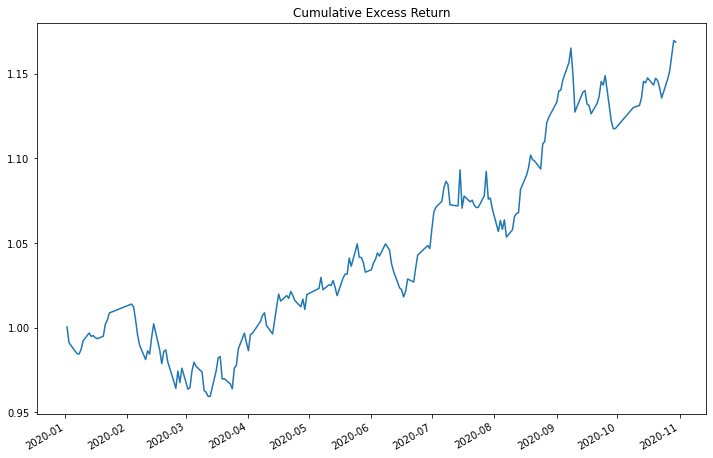

rtn p.a.: 0.20347458712759714
sharpe ratio: 1.852970584314679


In [73]:
anomaly_name = 'ORGrowthQoQ'
suffix = '0000'
anomaly = pd.read_csv(os.path.join(DATA_ROOT, f'data/payoffs/anomaly/{anomaly_name}.csv'), index_col=0, parse_dates=True)[[f'{anomaly_name}_{suffix}']]
analyse_factor_on_model(anomaly , "FF3", "simplified", START_DATE, END_DATE, regression_length=0)

suffix = '0010'
anomaly = pd.read_csv(os.path.join(DATA_ROOT, f'data/payoffs/anomaly/{anomaly_name}.csv'), index_col=0, parse_dates=True)[[f'{anomaly_name}_{suffix}']]
analyse_factor_on_model(anomaly , "FF3", "simplified", START_DATE, END_DATE, regression_length=0)

suffix = '0001'
anomaly = pd.read_csv(os.path.join(DATA_ROOT, f'data/payoffs/anomaly/{anomaly_name}.csv'), index_col=0, parse_dates=True)[[f'{anomaly_name}_{suffix}']]
analyse_factor_on_model(anomaly , "FF3", "simplified", START_DATE, END_DATE, regression_length=0)

suffix = '0011'
anomaly = pd.read_csv(os.path.join(DATA_ROOT, f'data/payoffs/anomaly/{anomaly_name}.csv'), index_col=0, parse_dates=True)[[f'{anomaly_name}_{suffix}']]
analyse_factor_on_model(anomaly , "FF3", "simplified", START_DATE, END_DATE, regression_length=0)

除了0010之外都还可以

## 因子合成 2020-10

根据之前的因子分析选择因子的编制方法和因子评分

第一类: 持有

包括:
1. ROEDifferenceYoY_0000
2. ROADifferenceYoY_0000
3. ORGrowthYoY_0000
4. NIGrowthYoY_0000 (低配)
5. NiGrowthQoQ_0001 (超配)
6. BrrEGRO_0011
7. ORGrowthQoQ_0001

第二类: 观察

包括:
1. BrrSGRO
2. OCFGrowthYoY

第一类因子从2017年1月1日开始的表现为:

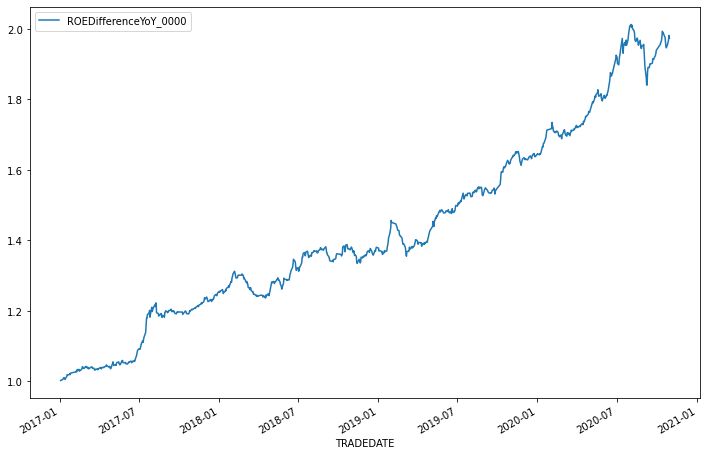

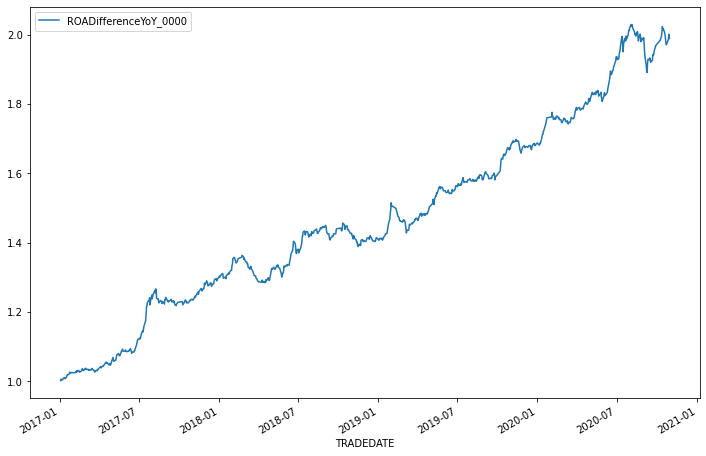

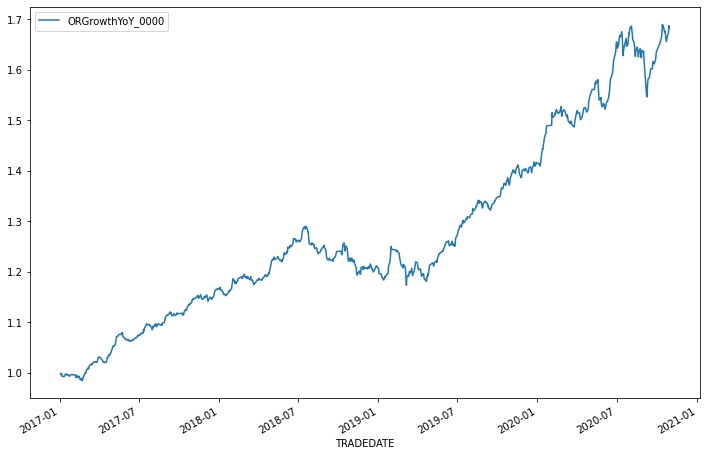

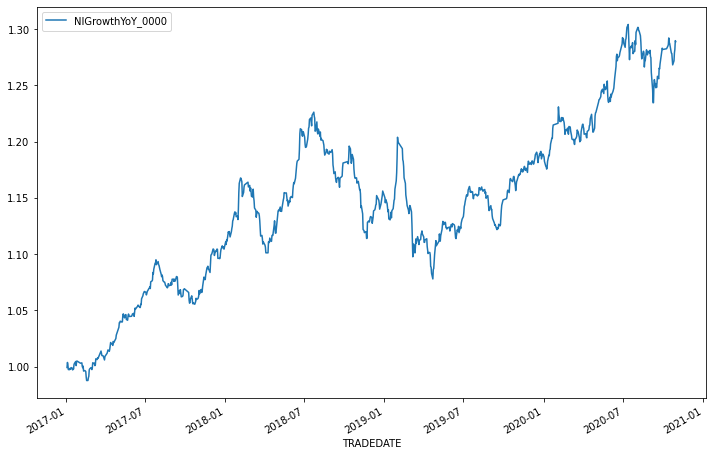

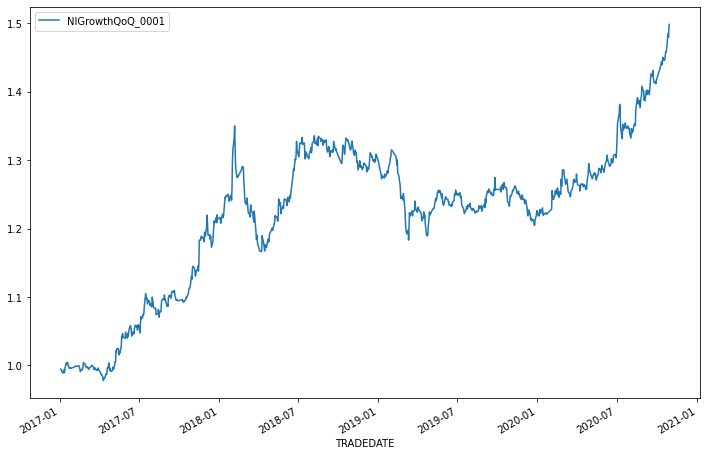

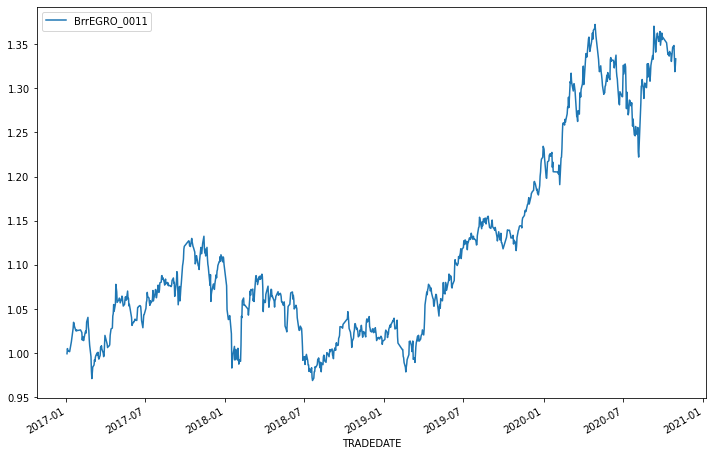

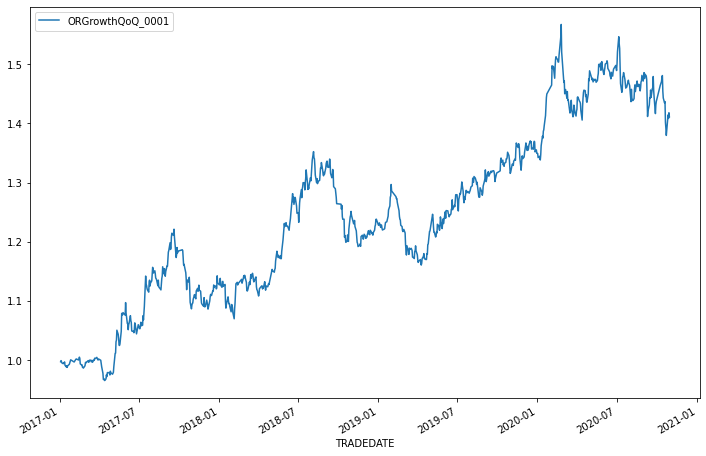

In [78]:
START_DATE = pd.to_datetime('2017-01-01')
END_DATE = pd.to_datetime('2020-10-31')
display_anomaly('ROEDifferenceYoY', suffix='0000')
display_anomaly('ROADifferenceYoY', suffix='0000')
display_anomaly('ORGrowthYoY', suffix='0000')
display_anomaly('NIGrowthYoY', suffix='0000')
display_anomaly('NIGrowthQoQ', suffix='0001')
display_anomaly('BrrEGRO', suffix='0011')
display_anomaly('ORGrowthQoQ', suffix='0001')
START_DATE = pd.to_datetime('2020-01-01')
END_DATE = pd.to_datetime('2020-10-31')

### 合成方法一

每个因子做一个 Long-Only 策略, 然后组合到一起

### 合成方法二

因子用z-score合成之后产生一个 Long-Only 策略